In [1]:
!nvidia-smi

Wed Aug 19 12:28:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import layers, Sequential

from sklearn.model_selection import train_test_split
import string

seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)

ImageGen_coeff = 10
epochs_num = 15

path = '/content/gdrive/My Drive/Dacon/ComputerVision/'

path_train = path + 'train.csv'
path_test = path + 'test.csv'
path_submission = path + 'submission.csv'

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
def read_data_to_dataframe(path):
    return pd.read_csv(path)

def image_view(pdSeries):
    pixels = np.array(pdSeries.iloc[3:].map(lambda x : float(x))).reshape((28,28))
    plt.rcParams['figure.figsize'] = [8, 8]
    plt.imshow(pixels)
    plt.title("Digit : " + str(pdSeries.iloc[1]) + "   Letter" + str(pdSeries.iloc[2]), fontsize = 15)
    plt.show()

def generate_letter_hash():
    letter_hash = dict(zip(string.ascii_uppercase, [[1 if i == j else 0 for j in range(26)] for i in range(26) ]))
    return letter_hash

def data_split(train_data):
    pix = train_data.iloc[:, 3:].applymap(lambda x : x/255.).values.reshape(-1, 28, 28, 1)                               #normalize 안했음
    fix = train_data.iloc[:, 1:3].values

    datagenerator = ImageDataGenerator(rotation_range=10, zoom_range=0.10, width_shift_range=0.1,
                                       height_shift_range=0.1)
    gen = datagenerator.flow(pix, fix, shuffle = False, batch_size = 32)
    pixel, fixed, batch_index, limit = [], [], 0, 64 * ImageGen_coeff
    while batch_index <= limit:
        try:
            data = gen.next()
            pixel += list(data[0])
            fixed += list(data[1])
            batch_index += 1
        except:
            print("ImageGeneratorError")
            break
    fixed = np.asarray(fixed)
    pixel = np.asarray(pixel)

    X_train_pixel, X_valid_pixel, fixed_train, fixed_valid = train_test_split(pixel, fixed, test_size=0.2,
                                                                              random_state=seed)

    Y_train = to_categorical(fixed_train[:, 0], 10)
    Y_valid = to_categorical(fixed_valid[:, 0], 10)

    letter_hash = generate_letter_hash()
    X_train_label = np.asarray([letter_hash[letter] for letter in fixed_train[:, 1]])
    X_valid_label = np.asarray([letter_hash[letter] for letter in fixed_valid[:, 1]])

    return X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid

In [ ]:
train_data = read_data_to_dataframe(path_train)
print(len(train_data))
train_data.head()

2048


,id,digit,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,4,4,3,0,4,3,3,3,4,4,0,0,1,1,3,4,0,4,2,0,4,0,1,3,1,0,4,1,1,3,...,4,3,4,1,3,0,0,1,3,3,3,0,3,2,2,1,0,1,0,0,3,0,0,4,2,0,3,4,1,1,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,1,4,2,0,3,4,0,0,2,3,4,0,3,4,3,0,2,2,1,4,2,3,3,4,1,2,4,2,0,3,...,4,2,3,0,0,0,0,4,3,2,2,4,2,1,1,1,3,3,1,2,4,4,4,2,2,4,4,0,4,2,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,0,2,1,3,2,2,2,4,1,1,4,1,0,1,3,4,2,2,2,4,1,1,2,0,3,0,2,3,4,0,...,3,0,4,0,3,0,2,0,1,4,2,3,4,4,4,0,2,0,4,4,1,3,0,3,2,0,2,3,0,2,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,3,4,3,1,0,3,2,2,0,3,4,1,0,4,1,2,2,3,2,2,0,2,0,3,0,3,2,4,0,0,...,0,3,0,1,4,1,3,1,2,1,1,1,2,2,2,4,3,4,3,0,4,1,2,4,1,4,0,1,0,4,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,4,2,4,2,1,4,1,1,4,4,0,2,3,4,4,3,3,3,3,4,1,0,3,0,3,0,0,0,1,1,...,2,1,3,2,1,4,2,3,2,2,1,0,4,2,2,1,2,1,0,3,2,2,2,2,1,4,2,1,2,1,4,4,3,2,1,3,4,3,1,2


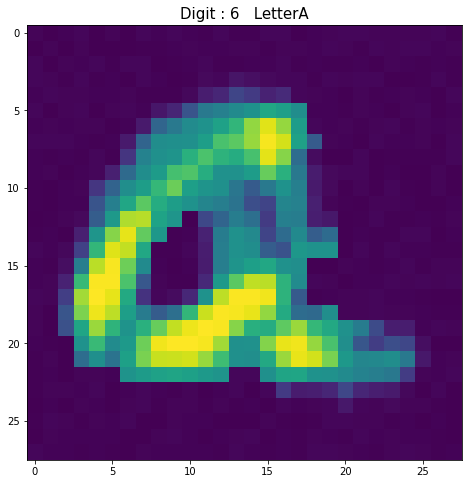

In [ ]:
image_view(train_data.iloc[4])

In [ ]:
X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid = data_split(train_data)
print(X_train_label.shape, X_train_pixel.shape, Y_train.shape, X_valid_label.shape, X_valid_pixel.shape, Y_valid.shape)

(16409, 26) (16409, 28, 28, 1) (16409, 10) (4103, 26) (4103, 28, 28, 1) (4103, 10)


In [ ]:
def multi_input_cnn_dense_model_1():
    cnn_input = layers.Input(shape = (28, 28, 1))
    cnn_mid = layers.Conv2D(32, kernel_size = 3, activation='relu')(cnn_input)
    cnn_mid = layers.Conv2D(32, kernel_size = 3, activation='relu')(cnn_mid)
    cnn_mid = layers.Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu')(cnn_mid)
    cnn_mid = layers.Dropout(0.4)(cnn_mid)
    cnn_mid = layers.Conv2D(64, kernel_size = 3, activation='relu')(cnn_mid)
    cnn_mid = layers.Conv2D(64, kernel_size = 3, activation='relu')(cnn_mid)
    cnn_mid = layers.Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu')(cnn_mid)
    cnn_mid = layers.Dropout(0.4)(cnn_mid)
    cnn_mid = layers.Conv2D(128, kernel_size = 4, activation='relu')(cnn_mid)
    cnn_output = layers.Flatten()(cnn_mid)
    cnn_model = tf.keras.Model(inputs = cnn_input, outputs = cnn_output)

    dense_input = layers.Input(shape=(26,))
    dense_mid = layers.Dense(26,activation = 'relu')(dense_input)
    dense_mid = layers.Dense(20,activation = 'relu')(dense_mid)
    dense_output = layers.Dense(10, activation='sigmoid')(dense_mid)
    dense_model = tf.keras.Model(inputs = dense_input, outputs = dense_output)

    concatenated = layers.concatenate([cnn_model.output, dense_model.output])
    concatenated = layers.Dense(32, activation = 'relu')(concatenated)
    concatenated = layers.BatchNormalization()(concatenated)
    concat_output = layers.Dense(10, activation='softmax')(concatenated)
    concat_model = tf.keras.models.Model([cnn_input, dense_input],concat_output)

    return concat_model

def plot_history(history):
    plt.rcParams['figure.figsize'] = [14, 14]
    fig = plt.figure()
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4)

    ax1.plot(history.history['accuracy'])
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')

    ax2.plot(history.history['loss'])
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')

    ax3.plot(history.history['val_loss'])
    ax3.set_xlabel('epoch')
    ax3.set_ylabel('val_loss')

    ax4.plot(history.history['val_accuracy'])
    ax4.set_xlabel('epoch')
    ax4.set_ylabel('val_accuracy')

    plt.show()


def train_and_save_model(ModelName ,model, epochs_num):
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    # print(model.summary())
    annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
    with tf.device('/device:GPU:0'):
        history = model.fit([X_train_pixel, X_train_label], Y_train, epochs=epochs_num,
                            validation_data=([X_valid_pixel, X_valid_label], Y_valid), callbacks=[annealer], verbose=1)
    model.save(path + ModelName + '.h5')
    print(
        f"CNN: Epochs={epochs_num:d}, " +
        f"Train accuracy={max(history.history['accuracy']):.5f}, " +
        f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
    )
    plot_history(history)


def test_result_submit(ModelName):
    model = tf.keras.models.load_model(path + ModelName + '.h5')
    letter_hash = generate_letter_hash()
    test_data = read_data_to_dataframe(path_test)

    X_test_pixel = test_data.iloc[:, 2:].applymap(lambda x : x/255.).values.reshape(-1, 28, 28, 1)
    X_test_label = np.array([letter_hash[letter] for letter in test_data.iloc[:, 1]])

    predicted = model.predict([X_test_pixel, X_test_label])
    res = np.array([int(np.argmax(x)) for x in predicted])

    submission = read_data_to_dataframe(path_submission)
    submission.loc[:,'digit'] = res
    submission.to_csv(path+'submission_'+ModelName+'.csv',index = False)

Epoch 1/15
513/513 [==============================] - 3s 7ms/step - loss: 1.6929 - accuracy: 0.3997 - val_loss: 1.1196 - val_accuracy: 0.6191
Epoch 2/15
513/513 [==============================] - 3s 6ms/step - loss: 0.9963 - accuracy: 0.6629 - val_loss: 0.7554 - val_accuracy: 0.7417
Epoch 3/15
513/513 [==============================] - 3s 6ms/step - loss: 0.7480 - accuracy: 0.7480 - val_loss: 0.6655 - val_accuracy: 0.7758
Epoch 4/15
513/513 [==============================] - 3s 6ms/step - loss: 0.6108 - accuracy: 0.7949 - val_loss: 0.5277 - val_accuracy: 0.8223
Epoch 5/15
513/513 [==============================] - 3s 6ms/step - loss: 0.5072 - accuracy: 0.8270 - val_loss: 0.4727 - val_accuracy: 0.8416
Epoch 6/15
513/513 [==============================] - 3s 6ms/step - loss: 0.4411 - accuracy: 0.8511 - val_loss: 0.3616 - val_accuracy: 0.8808
Epoch 7/15
513/513 [==============================] - 3s 6ms/step - loss: 0.3775 - accuracy: 0.8700 - val_loss: 0.3181 - val_accuracy: 0.8918
Epoch 

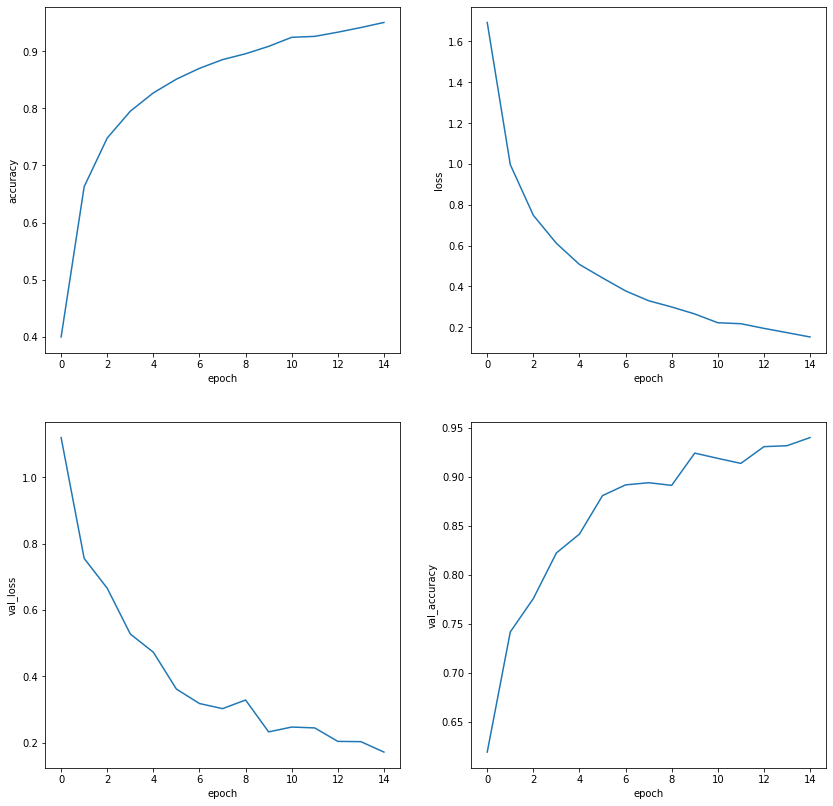

In [ ]:
model = multi_input_cnn_dense_model_1()
modelname = 'Model1'
train_and_save_model(modelname, model, epochs_num)
test_result_submit(ModelName = modelname)

normalize 안된걸로 1번, 된거 epoch40으로 1번, 된거 epoch15으로 1번 제출했고 87% 나옴.

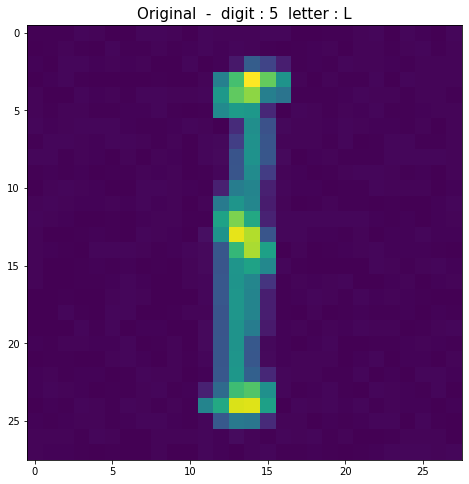

(8224, 28, 28, 1) (8224, 2)


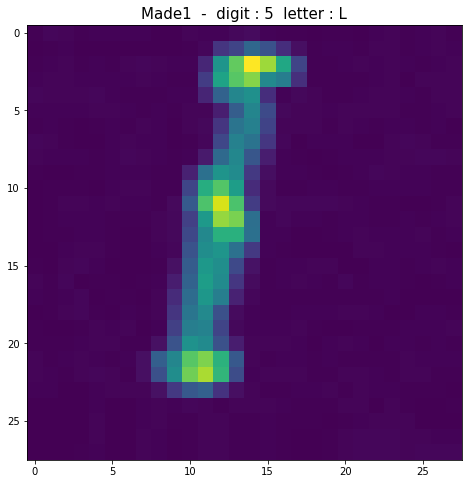

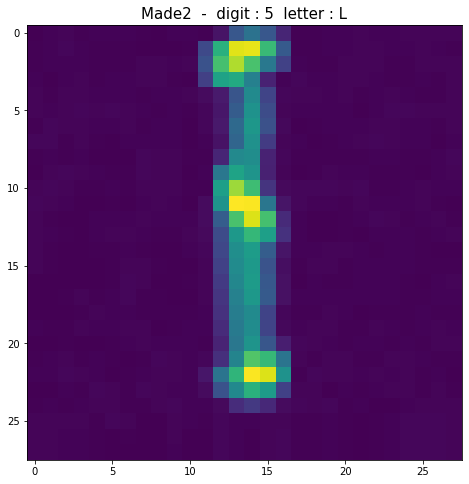

In [ ]:
def image_view2(reshapeddataset, title):
    plt.rcParams['figure.figsize'] = [8, 8]
    plt.imshow(reshapeddataset.reshape((28,28)))
    plt.title(title, fontsize = 15)
    plt.show()


def data_split(train_data):
    pix = train_data.iloc[:, 3:].values.reshape(-1, 28, 28, 1)
    fix = train_data.iloc[:, 1:3].values

    datagenerator = ImageDataGenerator(rotation_range=10, zoom_range=0.10, width_shift_range=0.1,
                                       height_shift_range=0.1)
    gen = datagenerator.flow(pix, fix, shuffle = False, batch_size = 32)
    image_view2(pix[0], 'Original  -  digit : ' + str(fix[0][0])+'  letter : ' + str(fix[0][1]))
    pixel, fixed = [], []
    batch_index = 0
    while batch_index <= 64 * ImageGen_coeff:
        try:
            data = gen.next()
            pixel += list(data[0])
            fixed += list(data[1])
            batch_index += 1
        except:
            print("ImageGeneratorError")
            break
    fixed = np.array(fixed)
    pixel = np.array(pixel)
    print(pixel.shape,fixed.shape)
    image_view2(pixel[0], 'Made1  -  digit : ' + str(fixed[0][0])+'  letter : ' + str(fixed[0][1]))
    image_view2(pixel[2048], 'Made2  -  digit : ' + str(fixed[2048][0])+'  letter : ' + str(fixed[2048][1]))

    X_train_pixel, X_valid_pixel, fixed_train, fixed_valid = train_test_split(pixel, fixed, test_size=0.2,
                                                                              random_state=seed)

    Y_train = fixed_train[:, 0]
    Y_valid = fixed_valid[:, 0]

    letter_hash = generate_letter_hash()
    X_train_label = np.array([letter_hash[letter] for letter in fixed_train[:, 1]])
    X_valid_label = np.array([letter_hash[letter] for letter in fixed_valid[:, 1]])

    return X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid

X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid = data_split(train_data)  

모델 수정 & test 까지 가능하도록 만들기
=========================

Found GPU at: /device:GPU:0
(16295, 26) (16295, 28, 28, 1) (16295, 10) (4074, 26) (4074, 28, 28, 1) (4074, 10)
Epoch 1/20
510/510 [==============================] - 7s 14ms/step - loss: 1.9128 - accuracy: 0.3038 - val_loss: 1.2255 - val_accuracy: 0.5785
Epoch 2/20
510/510 [==============================] - 6s 12ms/step - loss: 1.0540 - accuracy: 0.6380 - val_loss: 0.8013 - val_accuracy: 0.7315
Epoch 3/20
510/510 [==============================] - 6s 12ms/step - loss: 0.7612 - accuracy: 0.7393 - val_loss: 0.6037 - val_accuracy: 0.7919
Epoch 4/20
510/510 [==============================] - 6s 12ms/step - loss: 0.6157 - accuracy: 0.7831 - val_loss: 0.5467 - val_accuracy: 0.8122
Epoch 5/20
510/510 [==============================] - 6s 12ms/step - loss: 0.5203 - accuracy: 0.8172 - val_loss: 0.5391 - val_accuracy: 0.8174
Epoch 6/20
510/510 [==============================] - 7s 13ms/step - loss: 0.4437 - accuracy: 0.8441 - val_loss: 0.3807 - val_accuracy: 0.8652
Epoch 7/20
510/510 [===========

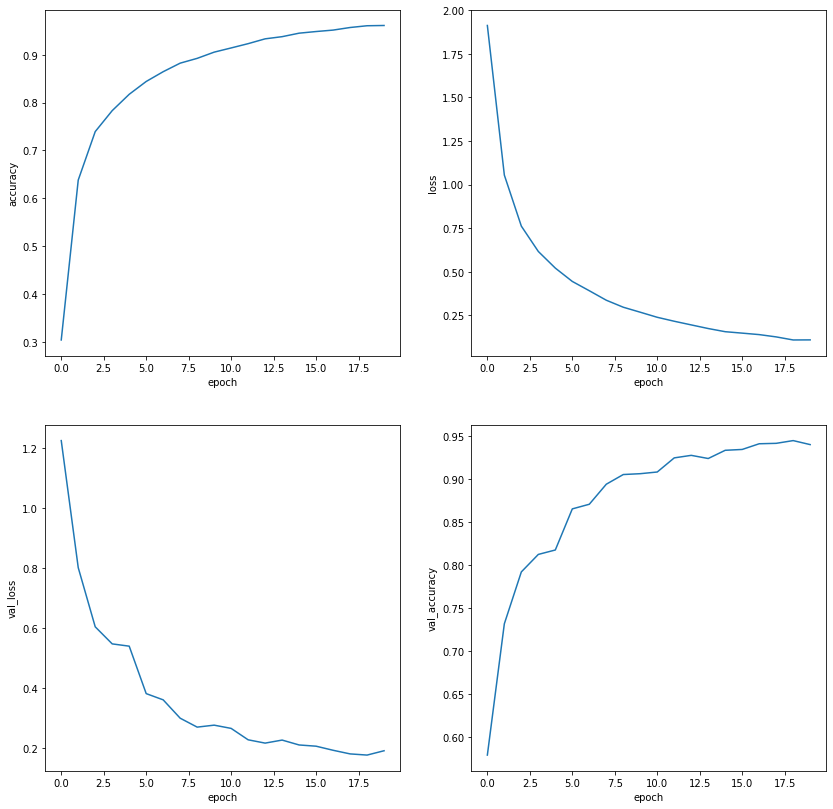

7/7 - 0s - loss: 0.7135 - accuracy: 0.8537
test_loss :  0.7134772539138794 test_acc :  0.8536585569381714
Epoch 1/20
510/510 [==============================] - 11s 22ms/step - loss: 2.1642 - accuracy: 0.1921 - val_loss: 1.7050 - val_accuracy: 0.3709
Epoch 2/20
510/510 [==============================] - 11s 21ms/step - loss: 1.2848 - accuracy: 0.5497 - val_loss: 0.8926 - val_accuracy: 0.7027
Epoch 3/20
510/510 [==============================] - 11s 21ms/step - loss: 0.8066 - accuracy: 0.7221 - val_loss: 0.6224 - val_accuracy: 0.7953
Epoch 4/20
510/510 [==============================] - 11s 21ms/step - loss: 0.5954 - accuracy: 0.7954 - val_loss: 0.5538 - val_accuracy: 0.8152
Epoch 5/20
510/510 [==============================] - 11s 21ms/step - loss: 0.4696 - accuracy: 0.8384 - val_loss: 0.4238 - val_accuracy: 0.8505
Epoch 6/20
510/510 [==============================] - 11s 21ms/step - loss: 0.3830 - accuracy: 0.8688 - val_loss: 0.3386 - val_accuracy: 0.8817
Epoch 7/20
510/510 [==========

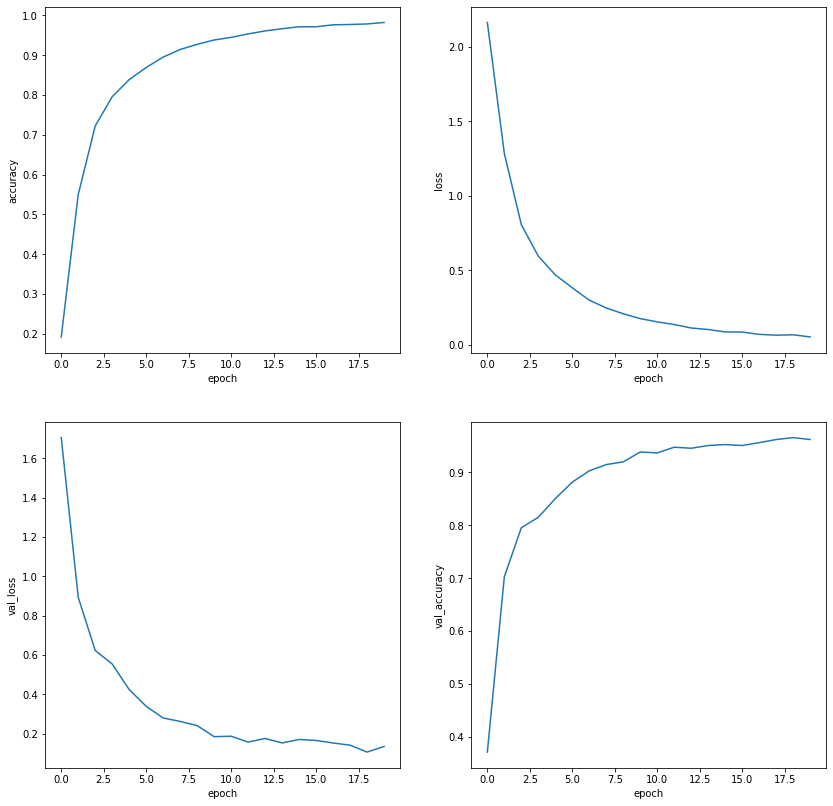

7/7 - 0s - loss: 0.9052 - accuracy: 0.8341
test_loss :  0.9051756858825684 test_acc :  0.8341463208198547
Epoch 1/20
510/510 [==============================] - 7s 13ms/step - loss: 1.8440 - accuracy: 0.3349 - val_loss: 1.2270 - val_accuracy: 0.5776
Epoch 2/20
510/510 [==============================] - 6s 11ms/step - loss: 1.0357 - accuracy: 0.6452 - val_loss: 0.7621 - val_accuracy: 0.7322
Epoch 3/20
510/510 [==============================] - 6s 11ms/step - loss: 0.7452 - accuracy: 0.7395 - val_loss: 0.6016 - val_accuracy: 0.7899
Epoch 4/20
510/510 [==============================] - 6s 11ms/step - loss: 0.5935 - accuracy: 0.7950 - val_loss: 0.5092 - val_accuracy: 0.8272
Epoch 5/20
510/510 [==============================] - 6s 11ms/step - loss: 0.4876 - accuracy: 0.8280 - val_loss: 0.4514 - val_accuracy: 0.8424
Epoch 6/20
510/510 [==============================] - 6s 11ms/step - loss: 0.4134 - accuracy: 0.8550 - val_loss: 0.3851 - val_accuracy: 0.8706
Epoch 7/20
510/510 [================

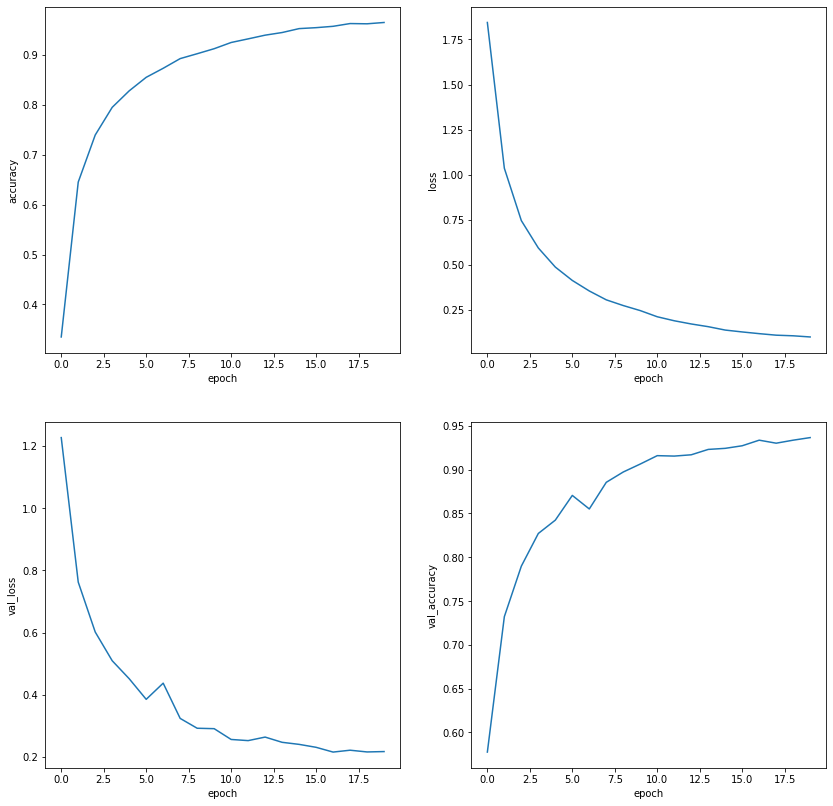

7/7 - 0s - loss: 0.9123 - accuracy: 0.8000
test_loss :  0.9123414754867554 test_acc :  0.800000011920929
Epoch 1/20
510/510 [==============================] - 6s 11ms/step - loss: 1.8466 - accuracy: 0.3364 - val_loss: 1.2581 - val_accuracy: 0.5555
Epoch 2/20
510/510 [==============================] - 5s 10ms/step - loss: 1.0937 - accuracy: 0.6205 - val_loss: 0.9055 - val_accuracy: 0.6937
Epoch 3/20
510/510 [==============================] - 5s 10ms/step - loss: 0.8290 - accuracy: 0.7089 - val_loss: 0.7075 - val_accuracy: 0.7514
Epoch 4/20
510/510 [==============================] - 6s 11ms/step - loss: 0.6687 - accuracy: 0.7662 - val_loss: 0.6122 - val_accuracy: 0.7798
Epoch 5/20
510/510 [==============================] - 5s 11ms/step - loss: 0.5775 - accuracy: 0.7985 - val_loss: 0.5528 - val_accuracy: 0.7973
Epoch 6/20
510/510 [==============================] - 5s 10ms/step - loss: 0.4938 - accuracy: 0.8305 - val_loss: 0.4678 - val_accuracy: 0.8351
Epoch 7/20
510/510 [=================

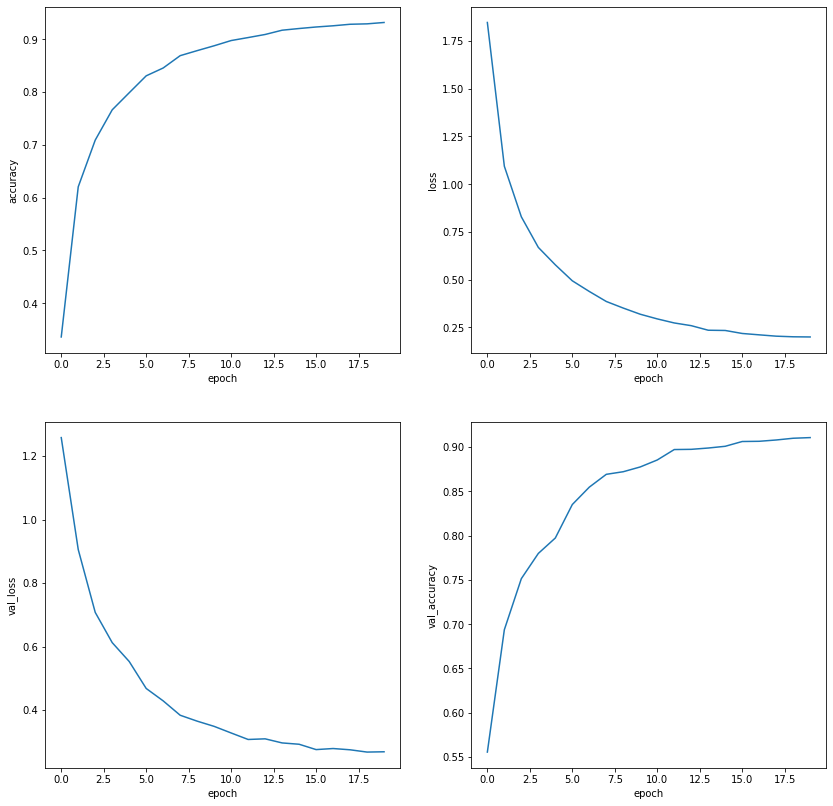

7/7 - 0s - loss: 0.7021 - accuracy: 0.7951
test_loss :  0.7021399736404419 test_acc :  0.795121967792511
Epoch 1/20
510/510 [==============================] - 11s 21ms/step - loss: 2.3064 - accuracy: 0.1116 - val_loss: 2.2962 - val_accuracy: 0.1213
Epoch 2/20
510/510 [==============================] - 10s 20ms/step - loss: 1.9189 - accuracy: 0.3015 - val_loss: 1.3673 - val_accuracy: 0.5449
Epoch 3/20
510/510 [==============================] - 10s 20ms/step - loss: 1.1272 - accuracy: 0.6050 - val_loss: 0.8559 - val_accuracy: 0.7121
Epoch 4/20
510/510 [==============================] - 10s 20ms/step - loss: 0.7910 - accuracy: 0.7268 - val_loss: 0.6611 - val_accuracy: 0.7747
Epoch 5/20
510/510 [==============================] - 10s 20ms/step - loss: 0.6097 - accuracy: 0.7896 - val_loss: 0.5318 - val_accuracy: 0.8137
Epoch 6/20
510/510 [==============================] - 11s 21ms/step - loss: 0.4929 - accuracy: 0.8277 - val_loss: 0.4282 - val_accuracy: 0.8510
Epoch 7/20
510/510 [===========

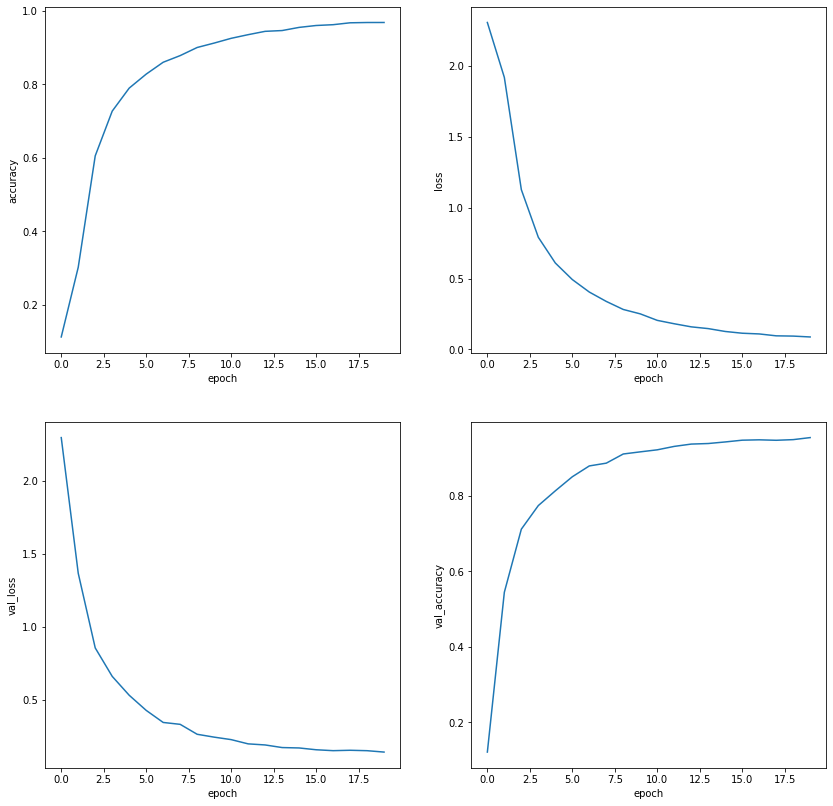

7/7 - 0s - loss: 0.7514 - accuracy: 0.8098
test_loss :  0.7513954639434814 test_acc :  0.8097561001777649


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import layers, Sequential

from sklearn.model_selection import train_test_split
import string

seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)

ImageGen_coeff = 10
epochs_num = 20
train_ratio = 0.9

path = '/content/gdrive/My Drive/Dacon/ComputerVision/'

path_train = path + 'train.csv'
path_test = path + 'test.csv'
path_submission = path + 'submission.csv'

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

def read_train_and_split(path,train_ratio):
    train = pd.read_csv(path)
    point_to = int(len(train) * train_ratio)
    train_data = train.iloc[:point_to]
    test_data = train.iloc[point_to:]
    return train_data, test_data

def generate_letter_hash():
    letter_hash = dict(zip(string.ascii_uppercase, [[1 if i == j else 0 for j in range(26)] for i in range(26) ]))
    return letter_hash

def data_split(train_data):
    pix = train_data.iloc[:, 3:].applymap(lambda x : x/255.).values.reshape(-1, 28, 28, 1)                               
    fix = train_data.iloc[:, 1:3].values

    datagenerator = ImageDataGenerator(rotation_range=10, zoom_range=0.10, width_shift_range=0.1,
                                       height_shift_range=0.1)
    gen = datagenerator.flow(pix, fix, shuffle = False, batch_size = 32)
    pixel, fixed, batch_index, limit = [], [], 0, 64 * ImageGen_coeff
    while batch_index <= limit:
        try:
            data = gen.next()
            pixel += list(data[0])
            fixed += list(data[1])
            batch_index += 1
        except:
            print("ImageGeneratorError")
            break
    fixed = np.asarray(fixed)
    pixel = np.asarray(pixel)

    X_train_pixel, X_valid_pixel, fixed_train, fixed_valid = train_test_split(pixel, fixed, test_size=0.2,
                                                                              random_state=seed)

    Y_train = to_categorical(fixed_train[:, 0], 10)
    Y_valid = to_categorical(fixed_valid[:, 0], 10)

    letter_hash = generate_letter_hash()
    X_train_label = np.asarray([letter_hash[letter] for letter in fixed_train[:, 1]])
    X_valid_label = np.asarray([letter_hash[letter] for letter in fixed_valid[:, 1]])

    return X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid

def plot_history(history):
    plt.rcParams['figure.figsize'] = [14, 14]
    fig = plt.figure()
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4)

    ax1.plot(history.history['accuracy'])
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')

    ax2.plot(history.history['loss'])
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')

    ax3.plot(history.history['val_loss'])
    ax3.set_xlabel('epoch')
    ax3.set_ylabel('val_loss')

    ax4.plot(history.history['val_accuracy'])
    ax4.set_xlabel('epoch')
    ax4.set_ylabel('val_accuracy')

    plt.show()

def train_model(model, epochs_num, rate):
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    annealer = LearningRateScheduler(lambda x: 1e-3 * rate ** x)
    with tf.device('/device:GPU:0'):
        history = model.fit([X_train_pixel, X_train_label], Y_train, epochs=epochs_num,
                            validation_data=([X_valid_pixel, X_valid_label], Y_valid), callbacks=[annealer], verbose=1)
    print(
        f"CNN: Epochs={epochs_num:d}, " +
        f"Train accuracy={max(history.history['accuracy']):.5f}, " +
        f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
    )
    plot_history(history)

    return model

def test_result(model, test_data):
    letter_hash = generate_letter_hash()

    X_test_pixel = test_data.iloc[:, 3:].applymap(lambda x : x/255.).values.reshape(-1, 28, 28, 1)
    X_test_label = np.array([letter_hash[letter] for letter in test_data.iloc[:, 2]])
    Y_test = to_categorical(test_data.iloc[:, 1], 10)

    test_loss, test_acc = model.evaluate([X_test_pixel, X_test_label],  Y_test, verbose=2)
    print('test_loss : ', test_loss, 'test_acc : ', test_acc)

train_data, test_data = read_train_and_split(path_train,train_ratio)
X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid = data_split(train_data)
print(X_train_label.shape, X_train_pixel.shape, Y_train.shape, X_valid_label.shape, X_valid_pixel.shape, Y_valid.shape)
################################################################################################################################1
def multi_input_cnn_dense_model_1():
    cnn_input = layers.Input(shape = (28, 28, 1))
    cnn_mid = layers.Conv2D(32, kernel_size=3, activation='relu')(cnn_input)
    cnn_mid = layers.Conv2D(32, kernel_size=3, activation='relu')(cnn_mid)
    cnn_mid = layers.Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu')(cnn_mid)
    cnn_mid = layers.Dropout(0.4)(cnn_mid)
    cnn_mid = layers.Conv2D(64, kernel_size=3, activation='relu')(cnn_mid)
    cnn_mid = layers.Conv2D(64, kernel_size=3, activation='relu')(cnn_mid)
    cnn_mid = layers.Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu')(cnn_mid)
    cnn_mid = layers.Dropout(0.4)(cnn_mid)
    cnn_mid = layers.Conv2D(128, kernel_size=4, activation='relu')(cnn_mid)
    cnn_output = layers.Flatten()(cnn_mid)
    cnn_model = tf.keras.Model(inputs = cnn_input, outputs = cnn_output)

    dense_input = layers.Input(shape=(26,))
    dense_mid = layers.Dense(52)(dense_input)
    dense_mid = layers.BatchNormalization()(dense_mid)
    dense_mid = layers.Activation('relu')(dense_mid)
    dense_mid = layers.Dense(52, activation = 'relu')(dense_mid)
    dense_mid = layers.Dropout(0.4)(dense_mid)
    dense_output = layers.Dense(52)(dense_mid)
    dense_model = tf.keras.Model(inputs = dense_input, outputs = dense_output)

    concatenated = layers.concatenate([cnn_model.output, dense_model.output])
    concatenated = layers.Dense(32, activation = 'relu')(concatenated)
    concat_output = layers.Dense(10, activation='softmax')(concatenated)
    concat_model = tf.keras.models.Model([cnn_input, dense_input],concat_output)

    return concat_model
try:
    model = multi_input_cnn_dense_model_1()
    plot_model(model, show_shapes=True)
    model = train_model(model, epochs_num, 0.95)
    test_result(model, test_data)
except:
    print("1 pass")
    pass

################################################################################################################################2
def multi_input_cnn_dense_model_1():
    cnn_input = layers.Input(shape = (28, 28, 1))
    cnn_res = layers.Conv2D(32, kernel_size = 3,  padding = 'same', activation = 'relu')(cnn_input)
    cnn_mid = layers.Conv2D(32, kernel_size = 3, padding = 'same', activation = 'relu')(cnn_res)
    cnn_mid = layers.add([cnn_mid, cnn_res])
    cnn_mid = layers.Conv2D(32, kernel_size = 5, strides=2, padding='same', activation = 'relu')(cnn_mid)
    cnn_mid = layers.Dropout(0.4)(cnn_mid)

    cnn_res = layers.Conv2D(64, kernel_size = 3,  padding = 'same', activation = 'relu')(cnn_mid)
    cnn_mid = layers.Conv2D(64, kernel_size = 3, padding = 'same', activation = 'relu')(cnn_res)
    cnn_mid = layers.add([cnn_mid, cnn_res])
    cnn_mid = layers.Conv2D(64, kernel_size = 5, strides=2, padding='same', activation = 'relu')(cnn_mid)
    cnn_mid = layers.Dropout(0.4)(cnn_mid)

    cnn_res = layers.Conv2D(128, kernel_size = 4, padding = 'same', activation = 'relu')(cnn_mid)
    cnn_mid = layers.Conv2D(128, kernel_size = 4, padding = 'same', activation = 'relu')(cnn_res)
    cnn_mid = layers.add([cnn_mid, cnn_res])
    cnn_mid = layers.Conv2D(128, kernel_size = 4, activation = 'relu')(cnn_mid)
    cnn_mid = layers.Conv2D(128, kernel_size = 4, activation='relu')(cnn_mid)
    cnn_output = layers.Flatten()(cnn_mid)
    cnn_model = tf.keras.Model(inputs = cnn_input, outputs = cnn_output)

    dense_input = layers.Input(shape=(26,))
    dense_mid = layers.Dense(52)(dense_input)
    dense_mid = layers.BatchNormalization()(dense_mid)
    dense_mid = layers.Activation('relu')(dense_mid)
    dense_mid = layers.Dense(52, activation = 'relu')(dense_mid)
    dense_mid = layers.Dropout(0.4)(dense_mid)
    dense_output = layers.Dense(52)(dense_mid)
    dense_model = tf.keras.Model(inputs = dense_input, outputs = dense_output)

    concatenated = layers.concatenate([cnn_model.output, dense_model.output])
    concatenated = layers.Dense(32, activation = 'relu')(concatenated)
    concat_output = layers.Dense(10, activation='softmax')(concatenated)
    concat_model = tf.keras.models.Model([cnn_input, dense_input],concat_output)

    return concat_model
try:
    model = multi_input_cnn_dense_model_1()
    plot_model(model, show_shapes=True)
    model = train_model(model, epochs_num, 0.95)
    test_result(model, test_data)
except:
    print("1 pass")
    pass

################################################################################################################################3
def multi_input_cnn_dense_model_1():
    cnn_input = layers.Input(shape = (28, 28, 1))
    cnn_mid = layers.Conv2D(32, kernel_size=3, activation='relu')(cnn_input)
    cnn_mid = layers.Conv2D(32, kernel_size=3, activation='relu')(cnn_mid)
    cnn_mid = layers.Conv2D(32, kernel_size=4, strides=2, padding='same', activation='relu')(cnn_mid)
    cnn_mid = layers.Dropout(0.4)(cnn_mid)
    cnn_mid = layers.Conv2D(64, kernel_size=3, activation='relu')(cnn_mid)
    cnn_mid = layers.Conv2D(64, kernel_size=3, activation='relu')(cnn_mid)
    cnn_mid = layers.Conv2D(64, kernel_size=4, strides=2, padding='same', activation='relu')(cnn_mid)
    cnn_mid = layers.Dropout(0.4)(cnn_mid)
    cnn_mid = layers.Conv2D(128, kernel_size=4, activation='relu')(cnn_mid)
    cnn_output = layers.Flatten()(cnn_mid)
    cnn_model = tf.keras.Model(inputs = cnn_input, outputs = cnn_output)

    dense_input = layers.Input(shape=(26,))
    dense_mid = layers.Dense(20)(dense_input)
    dense_mid = layers.BatchNormalization()(dense_mid)
    dense_mid = layers.Activation('relu')(dense_mid)
    dense_mid = layers.Dense(15, activation = 'relu')(dense_mid)
    dense_mid = layers.Dropout(0.4)(dense_mid)
    dense_output = layers.Dense(10)(dense_mid)
    dense_model = tf.keras.Model(inputs = dense_input, outputs = dense_output)

    concatenated = layers.concatenate([cnn_model.output, dense_model.output])
    concatenated = layers.Dense(32, activation = 'relu')(concatenated)
    concat_output = layers.Dense(10, activation='softmax')(concatenated)
    concat_model = tf.keras.models.Model([cnn_input, dense_input],concat_output)

    return concat_model
try:
    model = multi_input_cnn_dense_model_1()
    plot_model(model, show_shapes=True)
    model = train_model(model, epochs_num, 0.9)
    test_result(model, test_data)
except:
    print("1 pass")
    pass

################################################################################################################################4
def multi_input_cnn_dense_model_1():
    cnn_input = layers.Input(shape = (28, 28, 1))
    cnn_mid = layers.Conv2D(32, kernel_size=3, activation='relu')(cnn_input)
    cnn_mid = layers.Conv2D(32, kernel_size=4, strides=2, padding='same', activation='relu')(cnn_mid)
    cnn_mid = layers.Dropout(0.4)(cnn_mid)
    cnn_mid = layers.Conv2D(64, kernel_size=3, activation='relu')(cnn_mid)
    cnn_mid = layers.Conv2D(64, kernel_size=4, strides=2, padding='same', activation='relu')(cnn_mid)
    cnn_mid = layers.Dropout(0.4)(cnn_mid)
    cnn_mid = layers.Conv2D(128, kernel_size=4, activation='relu')(cnn_mid)
    cnn_output = layers.Flatten()(cnn_mid)
    cnn_model = tf.keras.Model(inputs = cnn_input, outputs = cnn_output)

    dense_input = layers.Input(shape=(26,))
    dense_mid = layers.Dense(20)(dense_input)
    dense_mid = layers.BatchNormalization()(dense_mid)
    dense_mid = layers.Activation('relu')(dense_mid)
    dense_mid = layers.Dense(15, activation = 'relu')(dense_mid)
    dense_mid = layers.Dropout(0.4)(dense_mid)
    dense_output = layers.Dense(10)(dense_mid)
    dense_model = tf.keras.Model(inputs = dense_input, outputs = dense_output)

    concatenated = layers.concatenate([cnn_model.output, dense_model.output])
    concatenated = layers.Dense(32, activation = 'relu')(concatenated)
    concat_output = layers.Dense(10, activation='softmax')(concatenated)
    concat_model = tf.keras.models.Model([cnn_input, dense_input],concat_output)

    return concat_model
try:
    model = multi_input_cnn_dense_model_1()
    plot_model(model, show_shapes=True)
    model = train_model(model, epochs_num, 0.85)
    test_result(model, test_data)
except:
    print("1 pass")
    pass

################################################################################################################################5
def multi_input_cnn_dense_model_1():
    cnn_input = layers.Input(shape = (28, 28, 1))
    cnn_res = layers.Conv2D(32, kernel_size = 3,  padding = 'same', activation = 'relu')(cnn_input)
    cnn_mid = layers.Conv2D(32, kernel_size = 3, padding = 'same', activation = 'relu')(cnn_res)
    cnn_mid = layers.add([cnn_mid, cnn_res])
    cnn_mid = layers.Conv2D(32, kernel_size = 5, strides=2, padding='same', activation = 'relu')(cnn_mid)
    cnn_mid = layers.Dropout(0.4)(cnn_mid)

    cnn_res = layers.Conv2D(64, kernel_size = 3,  padding = 'same', activation = 'relu')(cnn_mid)
    cnn_mid = layers.Conv2D(64, kernel_size = 3, padding = 'same', activation = 'relu')(cnn_res)
    cnn_mid = layers.add([cnn_mid, cnn_res])
    cnn_mid = layers.Conv2D(64, kernel_size = 5, strides=2, padding='same', activation = 'relu')(cnn_mid)
    cnn_mid = layers.Dropout(0.4)(cnn_mid)

    cnn_res = layers.Conv2D(128, kernel_size = 4, padding = 'same', activation = 'relu')(cnn_mid)
    cnn_mid = layers.Conv2D(128, kernel_size = 4, padding = 'same', activation = 'relu')(cnn_res)
    cnn_mid = layers.add([cnn_mid, cnn_res])
    cnn_mid = layers.Conv2D(96, kernel_size = 4, activation = 'relu')(cnn_mid)
    cnn_mid = layers.Conv2D(96, kernel_size = 4, activation='relu')(cnn_mid)
    cnn_output = layers.Flatten()(cnn_mid)
    cnn_model = tf.keras.Model(inputs = cnn_input, outputs = cnn_output)

    dense_input = layers.Input(shape=(26,))
    dense_mid = layers.Dense(20)(dense_input)
    dense_mid = layers.BatchNormalization()(dense_mid)
    dense_mid = layers.Activation('relu')(dense_mid)
    dense_mid = layers.Dense(15, activation = 'relu')(dense_mid)
    dense_mid = layers.Dropout(0.4)(dense_mid)
    dense_output = layers.Dense(10)(dense_mid)
    dense_model = tf.keras.Model(inputs = dense_input, outputs = dense_output)

    concatenated = layers.concatenate([cnn_model.output, dense_model.output])
    concatenated = layers.Dense(32, activation = 'relu')(concatenated)
    concat_output = layers.Dense(10, activation='softmax')(concatenated)
    concat_model = tf.keras.models.Model([cnn_input, dense_input],concat_output)

    return concat_model
try:
    model = multi_input_cnn_dense_model_1()
    plot_model(model, show_shapes=True)
    model = train_model(model, epochs_num, 0.85)
    test_result(model, test_data)
except:
    print("1 pass")
    pass

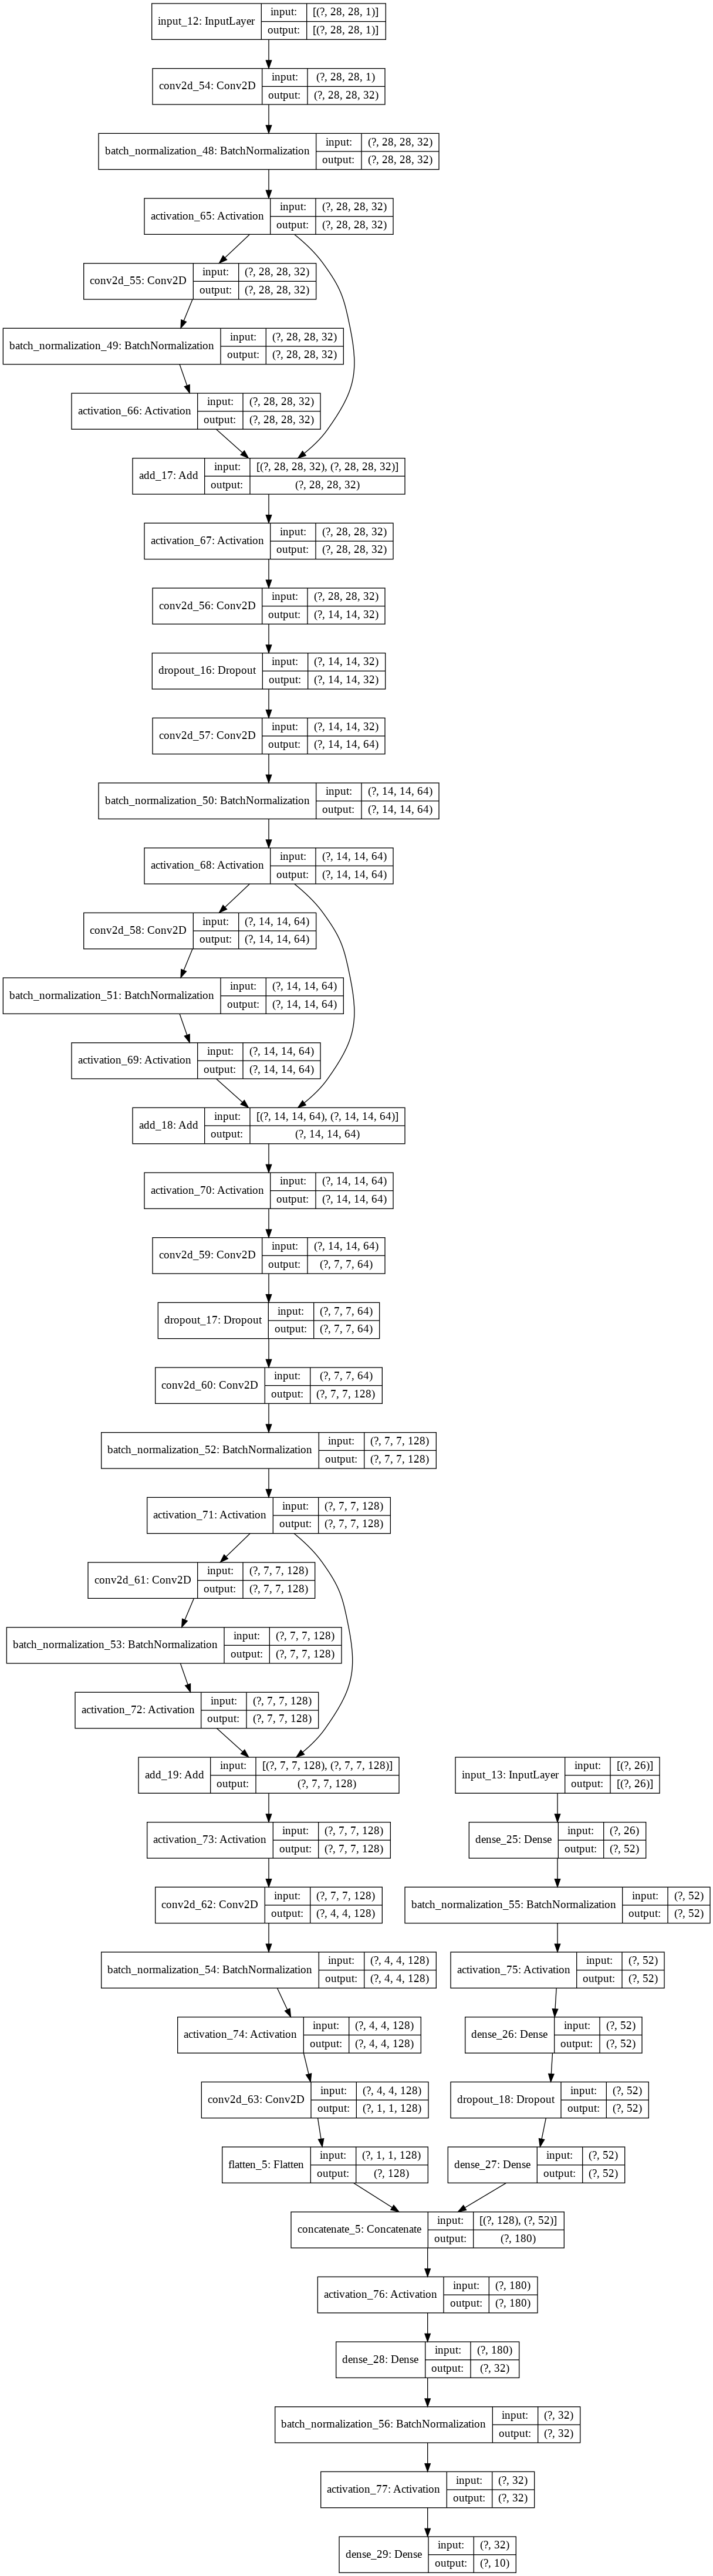

In [ ]:
plot_model(model, show_shapes=True)

3.임베딩 한 후 훈련
==================

Found GPU at: /device:GPU:0
(16295, 26) (16295, 28, 28, 1) (16295, 10) (4074, 26) (4074, 28, 28, 1) (4074, 10)
(22528, 28, 28, 1) (22528, 26)
training for embedding model
Epoch 1/50
564/564 [==============================] - 7s 12ms/step - loss: 6.0451 - accuracy: 0.0949 - val_loss: 5.0059 - val_accuracy: 0.1065
Epoch 2/50
564/564 [==============================] - 7s 12ms/step - loss: 4.8025 - accuracy: 0.1622 - val_loss: 5.8462 - val_accuracy: 0.0595
Epoch 3/50
564/564 [==============================] - 6s 11ms/step - loss: 4.7130 - accuracy: 0.2192 - val_loss: 4.9333 - val_accuracy: 0.2597
Epoch 4/50
564/564 [==============================] - 6s 11ms/step - loss: 4.5890 - accuracy: 0.2650 - val_loss: 4.5724 - val_accuracy: 0.2956
Epoch 5/50
564/564 [==============================] - 6s 11ms/step - loss: 4.6186 - accuracy: 0.2828 - val_loss: 4.5119 - val_accuracy: 0.3222
Epoch 6/50
564/564 [==============================] - 6s 11ms/step - loss: 4.4889 - accuracy: 0.2661 - val_loss: 4

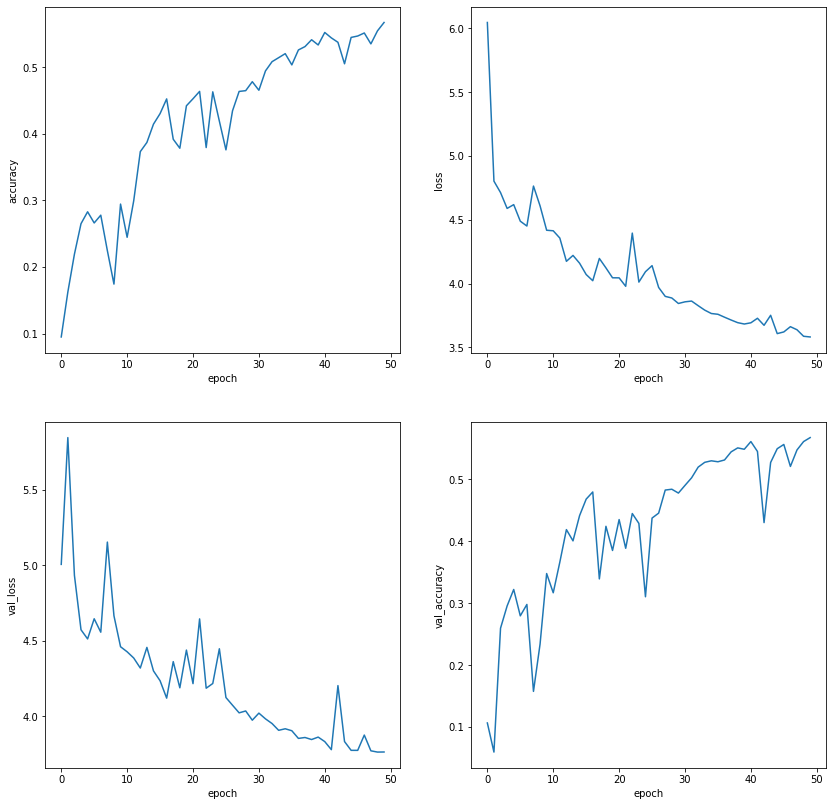

Epoch 1/20
510/510 [==============================] - 11s 21ms/step - loss: 2.3055 - accuracy: 0.1167 - val_loss: 2.3005 - val_accuracy: 0.1144
Epoch 2/20
510/510 [==============================] - 10s 20ms/step - loss: 2.2989 - accuracy: 0.1176 - val_loss: 2.3008 - val_accuracy: 0.1144
Epoch 3/20
510/510 [==============================] - 10s 20ms/step - loss: 2.2986 - accuracy: 0.1176 - val_loss: 2.3011 - val_accuracy: 0.1144
Epoch 4/20
510/510 [==============================] - 11s 21ms/step - loss: 2.2985 - accuracy: 0.1176 - val_loss: 2.3012 - val_accuracy: 0.1144
Epoch 5/20
510/510 [==============================] - 11s 21ms/step - loss: 2.2985 - accuracy: 0.1176 - val_loss: 2.3010 - val_accuracy: 0.1144
Epoch 6/20
510/510 [==============================] - 10s 20ms/step - loss: 2.2985 - accuracy: 0.1176 - val_loss: 2.3011 - val_accuracy: 0.1144
Epoch 7/20
510/510 [==============================] - 10s 21ms/step - loss: 2.2985 - accuracy: 0.1176 - val_loss: 2.3012 - val_accuracy:

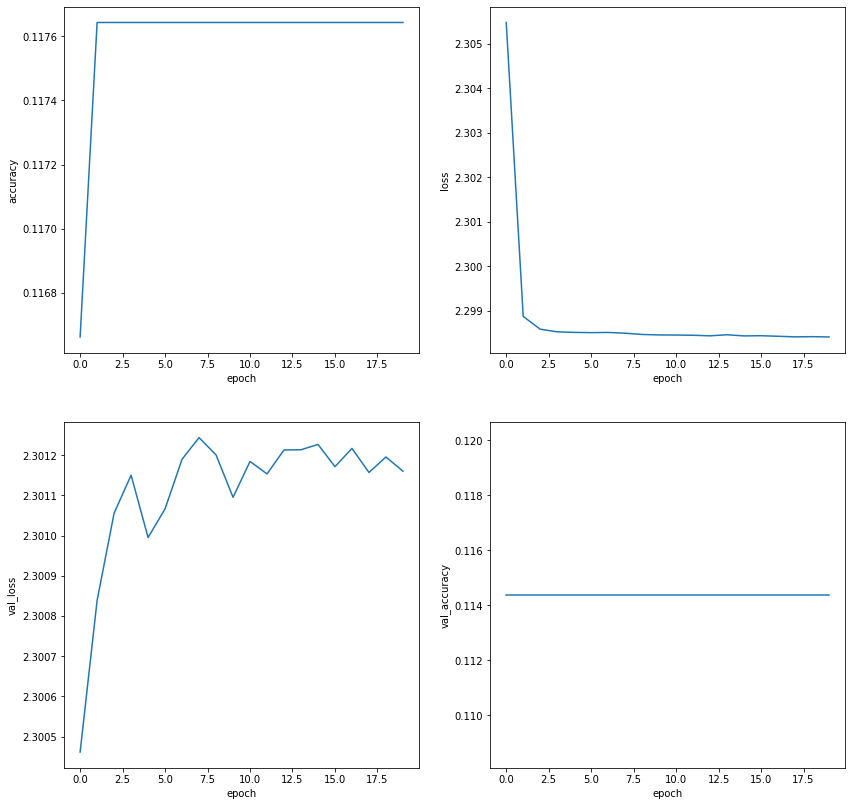

7/7 - 0s - loss: 2.3162 - accuracy: 0.0829
test_loss :  2.3162221908569336 test_acc :  0.08292683213949203


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import layers, Sequential

from sklearn.model_selection import train_test_split
import string

seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)

ImageGen_coeff = 10
epochs_num1 = 50
epochs_num2 = 20
train_ratio = 0.9

path = '/content/gdrive/My Drive/Dacon/ComputerVision/'

path_train = path + 'train.csv'
path_test = path + 'test.csv'
path_submission = path + 'submission.csv'

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

def read_train_and_split(path,train_ratio):
    train = pd.read_csv(path)
    point_to = int(len(train) * train_ratio)
    train_data = train.iloc[:point_to]
    test_data = train.iloc[point_to:]
    return train_data, test_data

def generate_letter_hash():
    letter_hash = dict(zip(string.ascii_uppercase, [[1 if i == j else 0 for j in range(26)] for i in range(26) ]))
    return letter_hash

def data_split(train_data):
    pix = train_data.iloc[:, 3:].applymap(lambda x : x/255.).values.reshape(-1, 28, 28, 1)                               
    fix = train_data.iloc[:, 1:3].values

    datagenerator = ImageDataGenerator(rotation_range=10, zoom_range=0.10, width_shift_range=0.1,
                                       height_shift_range=0.1)
    gen = datagenerator.flow(pix, fix, shuffle = False, batch_size = 32)
    pixel, fixed, batch_index, limit = [], [], 0, 64 * ImageGen_coeff
    while batch_index <= limit:
        try:
            data = gen.next()
            pixel += list(data[0])
            fixed += list(data[1])
            batch_index += 1
        except:
            print("ImageGeneratorError")
            break
    fixed = np.asarray(fixed)
    pixel = np.asarray(pixel)

    X_train_pixel, X_valid_pixel, fixed_train, fixed_valid = train_test_split(pixel, fixed, test_size=0.2,
                                                                              random_state=seed)

    Y_train = to_categorical(fixed_train[:, 0], 10)
    Y_valid = to_categorical(fixed_valid[:, 0], 10)

    letter_hash = generate_letter_hash()
    X_train_label = np.asarray([letter_hash[letter] for letter in fixed_train[:, 1]])
    X_valid_label = np.asarray([letter_hash[letter] for letter in fixed_valid[:, 1]])

    return X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid

def generate_letter_embedding(epochs_num):
    letter_hash = generate_letter_hash()

    train_data = pd.read_csv(path_train)
    test_data = pd.read_csv(path_test)
    Y = [letter_hash[letter] for letter in train_data.iloc[:,2]] + [letter_hash[letter] for letter in test_data.iloc[:,1]]
    Y = np.array(Y)
    X = np.concatenate((train_data.iloc[:,3:].values, test_data.iloc[:,2:].values), axis = 0).reshape(-1,28,28,1)
    print(X.shape, Y.shape)
    em_input = layers.Input(shape=(28, 28, 1))
    em_mid = layers.Conv2D(32, kernel_size=3, activation='relu')(em_input)
    em_mid = layers.Conv2D(32, kernel_size=3, activation='relu')(em_mid)
    em_mid = layers.Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu')(em_mid)
    em_mid = layers.Dropout(0.4)(em_mid)
    em_mid = layers.Conv2D(64, kernel_size=3, activation='relu')(em_mid)
    em_mid = layers.Conv2D(64, kernel_size=3, activation='relu')(em_mid)
    em_mid = layers.Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu')(em_mid)
    em_mid = layers.Dropout(0.4)(em_mid)
    em_mid = layers.Conv2D(128, kernel_size=4, activation='relu')(em_mid)
    em_output = layers.Flatten()(em_mid)

    train_mid = layers.Dense(64, activation='relu')(em_output)
    train_mid = layers.Dense(64, activation='relu')(train_mid)
    train_mid = layers.Dense(32, activation='relu')(train_mid)
    train_out = layers.Dense(26, activation='relu')(train_mid)

    em_model = tf.keras.Model(inputs=em_input, outputs=em_output)
    training_model = tf.keras.Model(inputs=em_input, outputs=train_out)

    training_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
    print('training for embedding model')
    with tf.device('/device:GPU:0'):
        history = training_model.fit(X, Y, epochs=epochs_num, validation_split = 0.2, callbacks=[annealer], verbose=1)
    print(
        f"CNN: Epochs={epochs_num:d}, " +
        f"Train accuracy={max(history.history['accuracy']):.5f}, " +
        f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
    )
    plot_history(history)

    return em_model

def multi_input_cnn_dense_model_1():
    cnn_input = layers.Input(shape = (28, 28, 1))
    cnn_res = layers.Conv2D(32, kernel_size = 3,  padding = 'same', activation = 'relu')(cnn_input)
    cnn_mid = layers.Conv2D(32, kernel_size = 3, padding = 'same', activation = 'relu')(cnn_res)
    cnn_mid = layers.add([cnn_mid, cnn_res])
    cnn_mid = layers.Conv2D(32, kernel_size = 5, strides=2, padding='same', activation = 'relu')(cnn_mid)
    cnn_mid = layers.Dropout(0.4)(cnn_mid)

    cnn_res = layers.Conv2D(64, kernel_size = 3,  padding = 'same', activation = 'relu')(cnn_mid)
    cnn_mid = layers.Conv2D(64, kernel_size = 3, padding = 'same', activation = 'relu')(cnn_res)
    cnn_mid = layers.add([cnn_mid, cnn_res])
    cnn_mid = layers.Conv2D(64, kernel_size = 5, strides=2, padding='same', activation = 'relu')(cnn_mid)
    cnn_mid = layers.Dropout(0.4)(cnn_mid)

    cnn_res = layers.Conv2D(128, kernel_size = 4, padding = 'same', activation = 'relu')(cnn_mid)
    cnn_mid = layers.Conv2D(128, kernel_size = 4, padding = 'same', activation = 'relu')(cnn_res)
    cnn_mid = layers.add([cnn_mid, cnn_res])
    cnn_mid = layers.Conv2D(128, kernel_size = 4, activation = 'relu')(cnn_mid)
    cnn_mid = layers.Conv2D(128, kernel_size = 4, activation='relu')(cnn_mid)
    cnn_output = layers.Flatten()(cnn_mid)
    cnn_model = tf.keras.Model(inputs = cnn_input, outputs = cnn_output)

    embedded = layers.Input(shape = (128,))

    concatenated = layers.add([cnn_model.output, embedded])
    concatenated = layers.Dense(128, activation = 'tanh')(concatenated)
    concatenated = layers.Dense(64, activation = 'selu')(concatenated)
    concatenated = layers.Dense(32, activation = 'relu')(concatenated)
    concat_output = layers.Dense(10, activation='softmax')(concatenated)
    concat_model = tf.keras.models.Model([cnn_input, embedded],concat_output)

    return concat_model

def plot_history(history):
    plt.rcParams['figure.figsize'] = [14, 14]
    fig = plt.figure()
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4)

    ax1.plot(history.history['accuracy'])
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')

    ax2.plot(history.history['loss'])
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')

    ax3.plot(history.history['val_loss'])
    ax3.set_xlabel('epoch')
    ax3.set_ylabel('val_loss')

    ax4.plot(history.history['val_accuracy'])
    ax4.set_xlabel('epoch')
    ax4.set_ylabel('val_accuracy')

    plt.show()


def train_model(model, epochs_num, em_model):
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
    with tf.device('/device:GPU:0'):
        history = model.fit([X_train_pixel, -1 * em_model.predict(X_train_pixel)], Y_train, epochs=epochs_num,
                            validation_data=([X_valid_pixel, -1 * em_model.predict(X_valid_pixel)], Y_valid), callbacks=[annealer], verbose=1)
    print(
        f"CNN: Epochs={epochs_num:d}, " +
        f"Train accuracy={max(history.history['accuracy']):.5f}, " +
        f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
    )
    plot_history(history)

    return model


def test_result(model, test_data, em_model):
    letter_hash = generate_letter_hash()

    X_test_pixel = test_data.iloc[:, 3:].applymap(lambda x : x/255.).values.reshape(-1, 28, 28, 1)
    X_test_label = np.array([letter_hash[letter] for letter in test_data.iloc[:, 2]])
    Y_test = to_categorical(test_data.iloc[:, 1], 10)

    test_loss, test_acc = model.evaluate([X_test_pixel, -1 * em_model(X_test_pixel)],  Y_test, verbose=2)
    print('test_loss : ', test_loss, 'test_acc : ', test_acc)

train_data, test_data = read_train_and_split(path_train,train_ratio)
X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid = data_split(train_data)
print(X_train_label.shape, X_train_pixel.shape, Y_train.shape, X_valid_label.shape, X_valid_pixel.shape, Y_valid.shape)
em_model = generate_letter_embedding(epochs_num1)
model = multi_input_cnn_dense_model_1()
plot_model(model, show_shapes=True)
model = train_model(model, epochs_num2, em_model)
test_result(model, test_data, em_model)

4.기존 + 임베딩
==============

Found GPU at: /device:GPU:0
(8165, 26) (8165, 28, 28, 1) (8165, 10) (2042, 26) (2042, 28, 28, 1) (2042, 10)
training for the original model
Epoch 1/20
256/256 - 2s - loss: 2.1785 - accuracy: 0.1865 - val_loss: 1.7978 - val_accuracy: 0.3639
Epoch 2/20
256/256 - 1s - loss: 1.5265 - accuracy: 0.4665 - val_loss: 1.2258 - val_accuracy: 0.5911
Epoch 3/20
256/256 - 1s - loss: 1.1346 - accuracy: 0.6048 - val_loss: 0.9364 - val_accuracy: 0.6792
Epoch 4/20
256/256 - 1s - loss: 0.9146 - accuracy: 0.6861 - val_loss: 0.7722 - val_accuracy: 0.7360
Epoch 5/20
256/256 - 2s - loss: 0.7788 - accuracy: 0.7285 - val_loss: 0.7310 - val_accuracy: 0.7498
Epoch 6/20
256/256 - 1s - loss: 0.6817 - accuracy: 0.7620 - val_loss: 0.6382 - val_accuracy: 0.7850
Epoch 7/20
256/256 - 1s - loss: 0.6019 - accuracy: 0.7909 - val_loss: 0.6495 - val_accuracy: 0.7791
Epoch 8/20
256/256 - 2s - loss: 0.5275 - accuracy: 0.8192 - val_loss: 0.5432 - val_accuracy: 0.8124
Epoch 9/20
256/256 - 2s - loss: 0.4624 - accuracy: 0.8364 - 

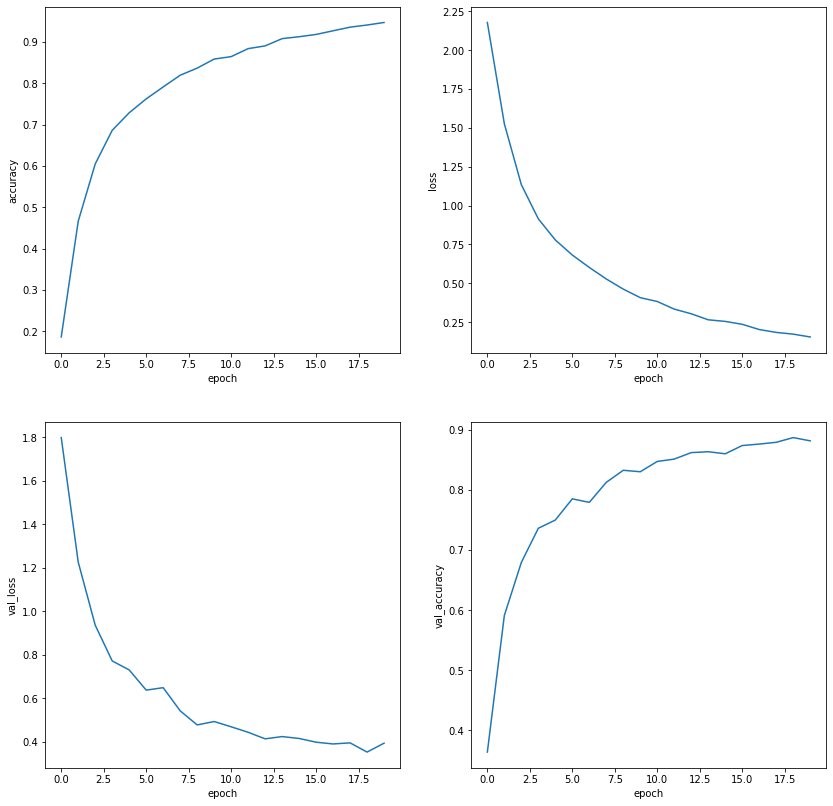

7/7 - 0s - loss: 0.7640 - accuracy: 0.8293
test_loss :  0.7639862298965454 test_acc :  0.8292682766914368
testing for medel 1
(22528, 28, 28, 1) (22528, 26)
training for embedding model
Epoch 1/30
564/564 - 3s - loss: 2.0368 - accuracy: 0.4002 - val_loss: 0.9767 - val_accuracy: 0.7230
Epoch 2/30
564/564 - 3s - loss: 0.8357 - accuracy: 0.7435 - val_loss: 0.5374 - val_accuracy: 0.8298
Epoch 3/30
564/564 - 3s - loss: 0.5442 - accuracy: 0.8271 - val_loss: 0.4212 - val_accuracy: 0.8511
Epoch 4/30
564/564 - 3s - loss: 0.4302 - accuracy: 0.8626 - val_loss: 0.3190 - val_accuracy: 0.8897
Epoch 5/30
564/564 - 3s - loss: 0.3613 - accuracy: 0.8827 - val_loss: 0.3015 - val_accuracy: 0.8964
Epoch 6/30
564/564 - 3s - loss: 0.3114 - accuracy: 0.8987 - val_loss: 0.2531 - val_accuracy: 0.9128
Epoch 7/30
564/564 - 3s - loss: 0.2742 - accuracy: 0.9088 - val_loss: 0.2539 - val_accuracy: 0.9108
Epoch 8/30
564/564 - 3s - loss: 0.2500 - accuracy: 0.9143 - val_loss: 0.2239 - val_accuracy: 0.9257
Epoch 9/30
564

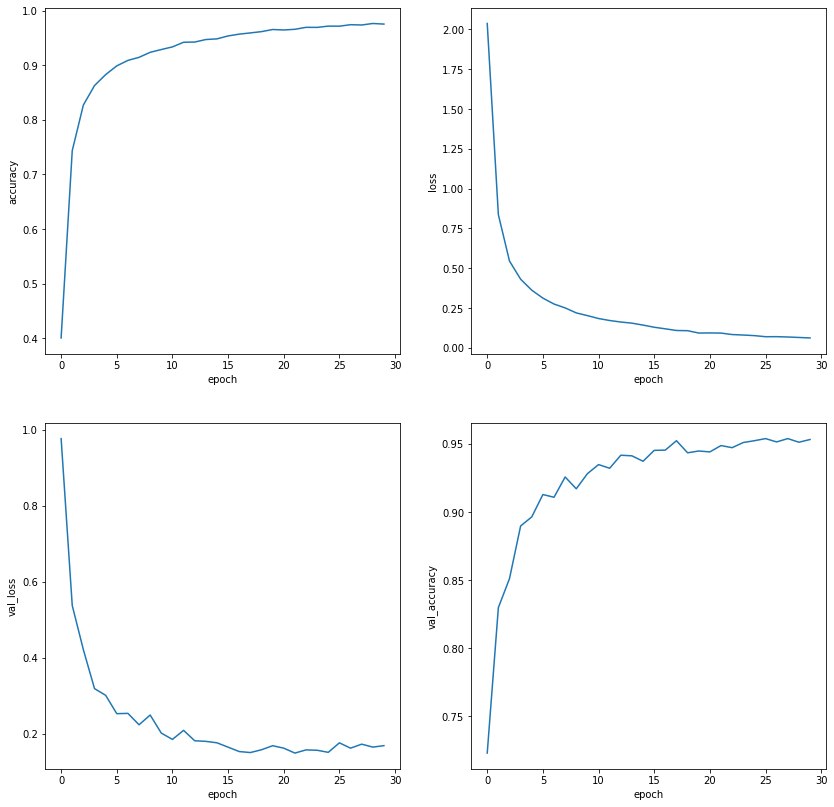

Epoch 1/20
256/256 - 2s - loss: 2.3154 - accuracy: 0.1358 - val_loss: 2.0877 - val_accuracy: 0.2214
Epoch 2/20
256/256 - 2s - loss: 1.7822 - accuracy: 0.3678 - val_loss: 1.4505 - val_accuracy: 0.4789
Epoch 3/20
256/256 - 2s - loss: 1.3151 - accuracy: 0.5418 - val_loss: 1.1208 - val_accuracy: 0.6185
Epoch 4/20
256/256 - 1s - loss: 1.0430 - accuracy: 0.6461 - val_loss: 0.9437 - val_accuracy: 0.6763
Epoch 5/20
256/256 - 1s - loss: 0.8718 - accuracy: 0.7035 - val_loss: 0.8336 - val_accuracy: 0.7204
Epoch 6/20
256/256 - 1s - loss: 0.7624 - accuracy: 0.7397 - val_loss: 0.6958 - val_accuracy: 0.7498
Epoch 7/20
256/256 - 1s - loss: 0.6655 - accuracy: 0.7750 - val_loss: 0.6504 - val_accuracy: 0.7850
Epoch 8/20
256/256 - 1s - loss: 0.5926 - accuracy: 0.8006 - val_loss: 0.6105 - val_accuracy: 0.7875
Epoch 9/20
256/256 - 1s - loss: 0.5283 - accuracy: 0.8180 - val_loss: 0.5688 - val_accuracy: 0.8051
Epoch 10/20
256/256 - 1s - loss: 0.4828 - accuracy: 0.8288 - val_loss: 0.5096 - val_accuracy: 0.8208

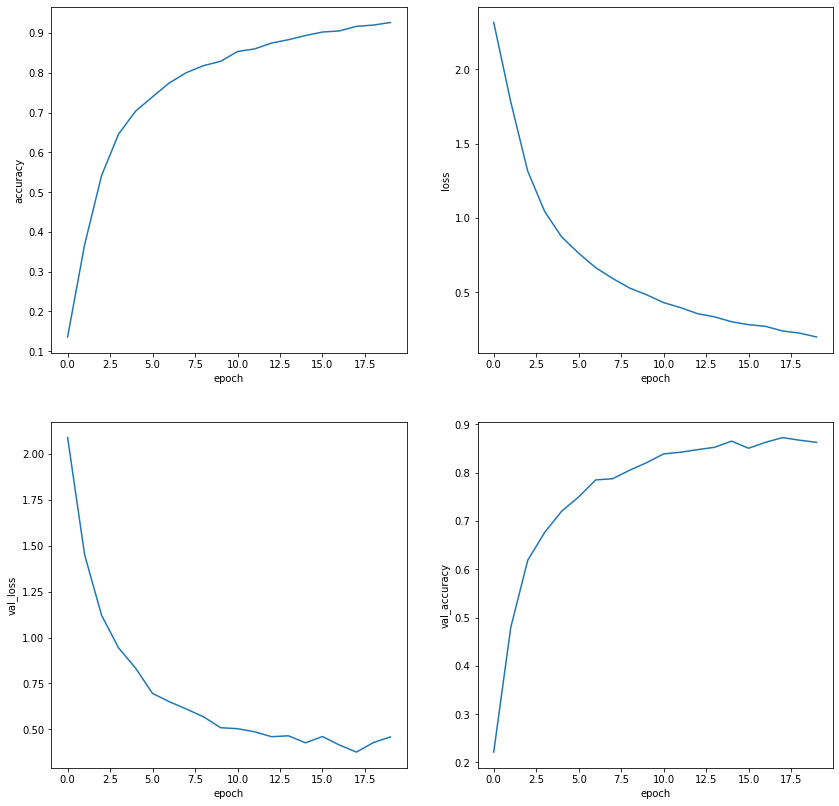

7/7 - 0s - loss: 0.7336 - accuracy: 0.8293
test_loss :  0.7336477041244507 test_acc :  0.8292682766914368
(22528, 28, 28, 1) (22528, 26)
training for embedding model
Epoch 1/30
564/564 - 8s - loss: 1.2216 - accuracy: 0.6439 - val_loss: 0.6280 - val_accuracy: 0.7987
Epoch 2/30
564/564 - 7s - loss: 0.4838 - accuracy: 0.8429 - val_loss: 0.4685 - val_accuracy: 0.8444
Epoch 3/30
564/564 - 7s - loss: 0.3321 - accuracy: 0.8890 - val_loss: 0.4112 - val_accuracy: 0.8577
Epoch 4/30
564/564 - 7s - loss: 0.2612 - accuracy: 0.9093 - val_loss: 0.3153 - val_accuracy: 0.8924
Epoch 5/30
564/564 - 7s - loss: 0.2115 - accuracy: 0.9251 - val_loss: 0.3306 - val_accuracy: 0.8893
Epoch 6/30
564/564 - 7s - loss: 0.1603 - accuracy: 0.9433 - val_loss: 0.3091 - val_accuracy: 0.8966
Epoch 7/30
564/564 - 7s - loss: 0.1380 - accuracy: 0.9495 - val_loss: 0.2790 - val_accuracy: 0.9143
Epoch 8/30
564/564 - 7s - loss: 0.1103 - accuracy: 0.9581 - val_loss: 0.2871 - val_accuracy: 0.9081
Epoch 9/30
564/564 - 7s - loss: 0.

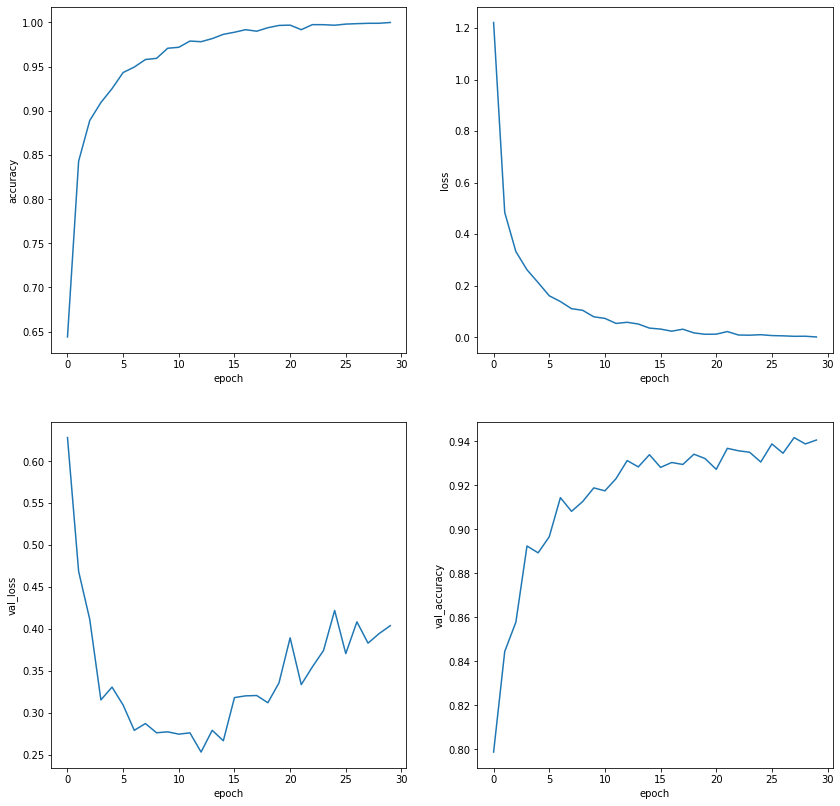

Epoch 1/20
256/256 - 2s - loss: 2.3683 - accuracy: 0.1103 - val_loss: 2.3001 - val_accuracy: 0.1219
Epoch 2/20
256/256 - 2s - loss: 2.3005 - accuracy: 0.1171 - val_loss: 2.2988 - val_accuracy: 0.1219
Epoch 3/20
256/256 - 1s - loss: 2.3009 - accuracy: 0.1181 - val_loss: 2.2983 - val_accuracy: 0.1219
Epoch 4/20
256/256 - 1s - loss: 2.2995 - accuracy: 0.1171 - val_loss: 2.2980 - val_accuracy: 0.1219
Epoch 5/20
256/256 - 1s - loss: 2.2994 - accuracy: 0.1171 - val_loss: 2.2978 - val_accuracy: 0.1219
Epoch 6/20
256/256 - 2s - loss: 2.2993 - accuracy: 0.1171 - val_loss: 2.2978 - val_accuracy: 0.1219
Epoch 7/20
256/256 - 2s - loss: 2.2993 - accuracy: 0.1171 - val_loss: 2.2978 - val_accuracy: 0.1219
Epoch 8/20
256/256 - 2s - loss: 2.2993 - accuracy: 0.1171 - val_loss: 2.2977 - val_accuracy: 0.1219
Epoch 9/20
256/256 - 1s - loss: 2.2993 - accuracy: 0.1171 - val_loss: 2.2978 - val_accuracy: 0.1219
Epoch 10/20
256/256 - 1s - loss: 2.2992 - accuracy: 0.1171 - val_loss: 2.2979 - val_accuracy: 0.1219

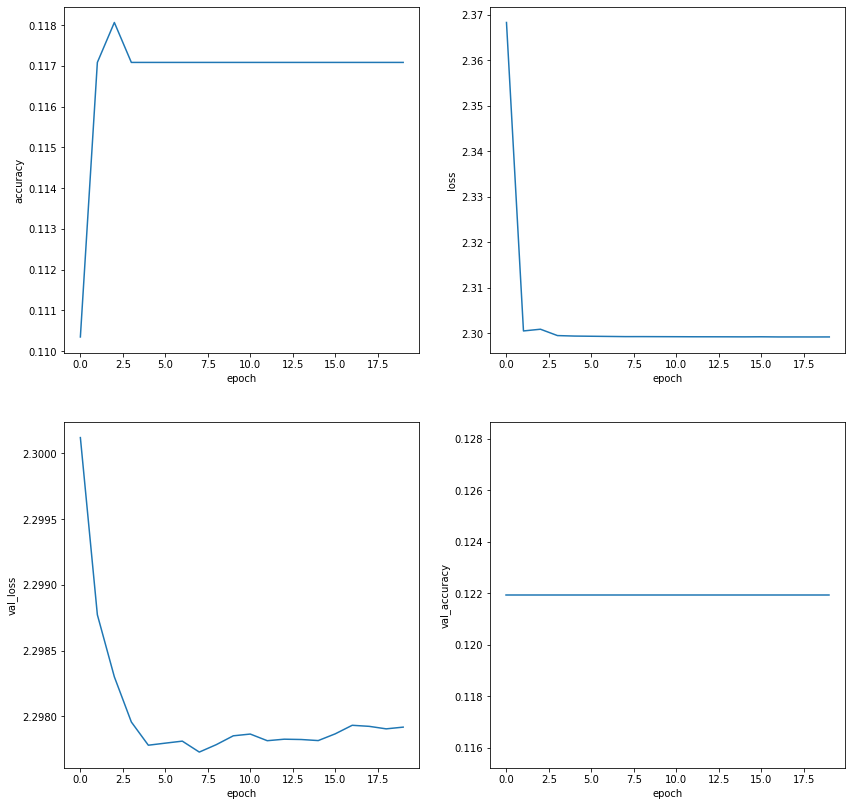

7/7 - 0s - loss: 2.3146 - accuracy: 0.0829
test_loss :  2.314589738845825 test_acc :  0.08292683213949203
testing for medel 3
(22528, 28, 28, 1) (22528, 26)
training for embedding model
Epoch 1/30
564/564 - 3s - loss: 2.1940 - accuracy: 0.3583 - val_loss: 1.0365 - val_accuracy: 0.6897
Epoch 2/30
564/564 - 3s - loss: 0.8669 - accuracy: 0.7395 - val_loss: 0.5284 - val_accuracy: 0.8338
Epoch 3/30
564/564 - 3s - loss: 0.5666 - accuracy: 0.8237 - val_loss: 0.4313 - val_accuracy: 0.8573
Epoch 4/30
564/564 - 3s - loss: 0.4346 - accuracy: 0.8621 - val_loss: 0.3261 - val_accuracy: 0.8928
Epoch 5/30
564/564 - 3s - loss: 0.3656 - accuracy: 0.8829 - val_loss: 0.3092 - val_accuracy: 0.8964
Epoch 6/30
564/564 - 3s - loss: 0.3064 - accuracy: 0.8986 - val_loss: 0.3038 - val_accuracy: 0.8975
Epoch 7/30
564/564 - 3s - loss: 0.2759 - accuracy: 0.9101 - val_loss: 0.2735 - val_accuracy: 0.9081
Epoch 8/30
564/564 - 3s - loss: 0.2498 - accuracy: 0.9147 - val_loss: 0.2461 - val_accuracy: 0.9121
Epoch 9/30
564

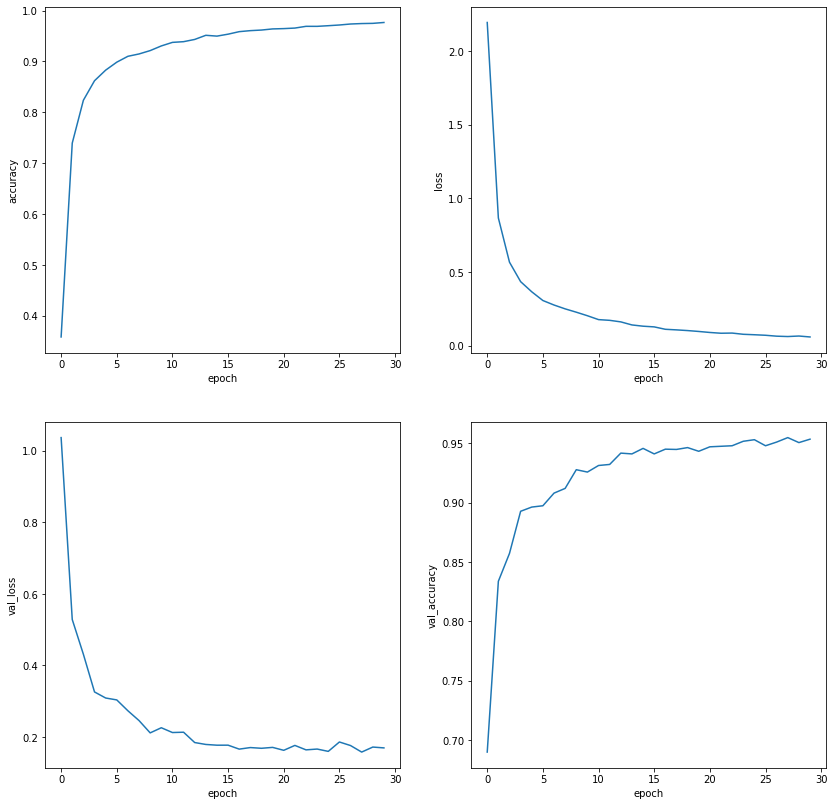

Epoch 1/20
256/256 - 2s - loss: 2.3831 - accuracy: 0.1198 - val_loss: 2.3006 - val_accuracy: 0.1219
Epoch 2/20
256/256 - 2s - loss: 2.3006 - accuracy: 0.1170 - val_loss: 2.2991 - val_accuracy: 0.1219
Epoch 3/20
256/256 - 2s - loss: 2.3001 - accuracy: 0.1170 - val_loss: 2.2986 - val_accuracy: 0.1219
Epoch 4/20
256/256 - 2s - loss: 2.2995 - accuracy: 0.1171 - val_loss: 2.2981 - val_accuracy: 0.1219
Epoch 5/20
256/256 - 2s - loss: 2.2994 - accuracy: 0.1171 - val_loss: 2.2979 - val_accuracy: 0.1219
Epoch 6/20
256/256 - 1s - loss: 2.2993 - accuracy: 0.1171 - val_loss: 2.2979 - val_accuracy: 0.1219
Epoch 7/20
256/256 - 2s - loss: 2.2993 - accuracy: 0.1171 - val_loss: 2.2979 - val_accuracy: 0.1219
Epoch 8/20
256/256 - 1s - loss: 2.2993 - accuracy: 0.1171 - val_loss: 2.2978 - val_accuracy: 0.1219
Epoch 9/20
256/256 - 1s - loss: 2.2993 - accuracy: 0.1171 - val_loss: 2.2978 - val_accuracy: 0.1219
Epoch 10/20
256/256 - 1s - loss: 2.2992 - accuracy: 0.1171 - val_loss: 2.2979 - val_accuracy: 0.1219

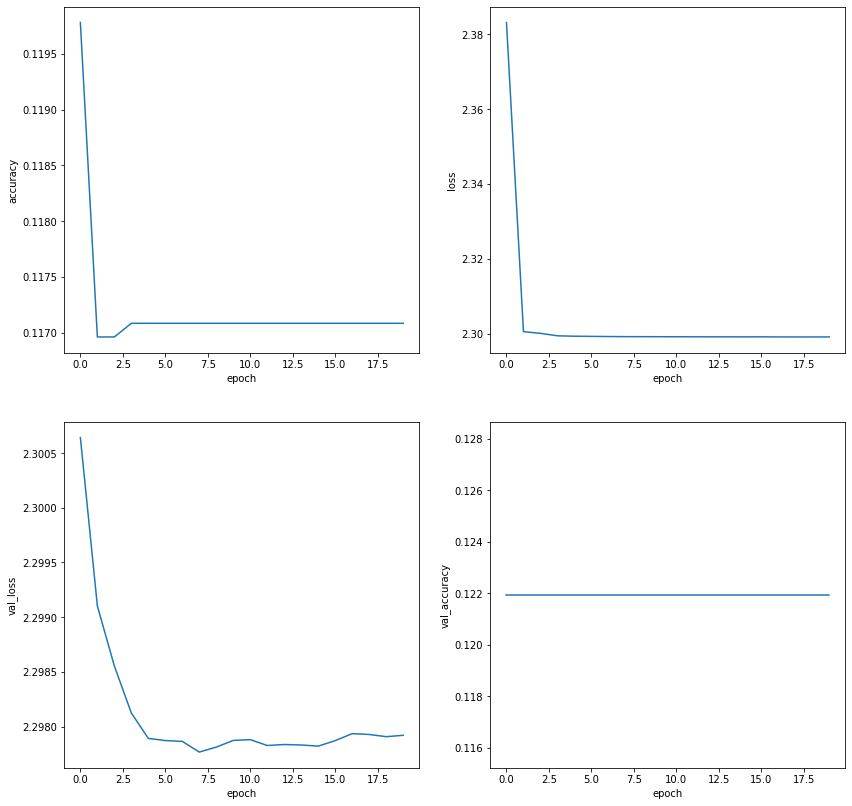

7/7 - 0s - loss: 2.7125 - accuracy: 0.0780
test_loss :  2.7124743461608887 test_acc :  0.07804878056049347


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import layers, Sequential

from sklearn.model_selection import train_test_split
import string

seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)
ImageGen_coeff = 5
epochs_num1 = 30  # embedding
epochs_num2 = 20  # classifier
train_ratio = 0.9
verbose = 2

path = '/content/gdrive/My Drive/Dacon/ComputerVision/'

path_train = path + 'train.csv'
path_test = path + 'test.csv'
path_submission = path + 'submission.csv'

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

def read_train_and_split(path,train_ratio):
    train = pd.read_csv(path)
    point_to = int(len(train) * train_ratio)
    train_data = train.iloc[:point_to]
    test_data = train.iloc[point_to:]
    return train_data, test_data

def generate_letter_hash():
    letter_hash = dict(zip(string.ascii_uppercase, [[1 if i == j else 0 for j in range(26)] for i in range(26) ]))
    return letter_hash

def data_split(train_data):
    pix = train_data.iloc[:, 3:].applymap(lambda x : x/255.).values.reshape(-1, 28, 28, 1)                               
    fix = train_data.iloc[:, 1:3].values

    datagenerator = ImageDataGenerator(rotation_range=10, zoom_range=0.10, width_shift_range=0.1,
                                       height_shift_range=0.1)
    gen = datagenerator.flow(pix, fix, shuffle = False, batch_size = 32)
    pixel, fixed, batch_index, limit = [], [], 0, 64 * ImageGen_coeff
    while batch_index <= limit:
        try:
            data = gen.next()
            pixel += list(data[0])
            fixed += list(data[1])
            batch_index += 1
        except:
            print("ImageGeneratorError")
            break
    fixed = np.asarray(fixed)
    pixel = np.asarray(pixel)

    X_train_pixel, X_valid_pixel, fixed_train, fixed_valid = train_test_split(pixel, fixed, test_size=0.2,
                                                                              random_state=seed)

    Y_train = to_categorical(fixed_train[:, 0], 10)
    Y_valid = to_categorical(fixed_valid[:, 0], 10)

    letter_hash = generate_letter_hash()
    X_train_label = np.asarray([letter_hash[letter] for letter in fixed_train[:, 1]])
    X_valid_label = np.asarray([letter_hash[letter] for letter in fixed_valid[:, 1]])

    return X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid

def plot_history(history):
    plt.rcParams['figure.figsize'] = [14, 14]
    fig = plt.figure()
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4)

    ax1.plot(history.history['accuracy'])
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')

    ax2.plot(history.history['loss'])
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')

    ax3.plot(history.history['val_loss'])
    ax3.set_xlabel('epoch')
    ax3.set_ylabel('val_loss')

    ax4.plot(history.history['val_accuracy'])
    ax4.set_xlabel('epoch')
    ax4.set_ylabel('val_accuracy')

    plt.show()

def train_model(model, epochs_num, rate, em_model):
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    annealer = LearningRateScheduler(lambda x: 1e-3 * rate ** x)
    with tf.device('/device:GPU:0'):
        history = model.fit([X_train_pixel, X_train_label, em_model.predict(X_train_pixel)], Y_train, epochs=epochs_num,
                            validation_data=([X_valid_pixel, X_valid_label, em_model.predict(X_valid_pixel)], Y_valid), callbacks=[annealer], verbose=verbose)
    print(
        f"CNN: Epochs={epochs_num:d}, " +
        f"Train accuracy={max(history.history['accuracy']):.5f}, " +
        f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
    )
    plot_history(history)

    return model

def test_result(model, test_data, em_model):
    letter_hash = generate_letter_hash()

    X_test_pixel = test_data.iloc[:, 3:].applymap(lambda x : x/255.).values.reshape(-1, 28, 28, 1)
    X_test_label = np.array([letter_hash[letter] for letter in test_data.iloc[:, 2]])
    Y_test = to_categorical(test_data.iloc[:, 1], 10)

    test_loss, test_acc = model.evaluate([X_test_pixel, X_test_label, em_model.predict(X_test_pixel)],  Y_test, verbose=2)
    print('test_loss : ', test_loss, 'test_acc : ', test_acc)
    return test_acc


train_data, test_data = read_train_and_split(path_train,train_ratio)
X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid = data_split(train_data)
print(X_train_label.shape, X_train_pixel.shape, Y_train.shape, X_valid_label.shape, X_valid_pixel.shape, Y_valid.shape)

################################################################################################################################0
print('training for the original model')
def train_and_save_model(model, epochs_num, rate):
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    annealer = LearningRateScheduler(lambda x: 1e-3 * rate ** x)
    with tf.device('/device:GPU:0'):
        history = model.fit([X_train_pixel, X_train_label], Y_train, epochs=epochs_num,
                            validation_data=([X_valid_pixel, X_valid_label], Y_valid), callbacks=[annealer], verbose=verbose)
    print(
        f"CNN: Epochs={epochs_num:d}, " +
        f"Train accuracy={max(history.history['accuracy']):.5f}, " +
        f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
    )
    plot_history(history)
    
    return model

def test_result0(model, test_data):
    letter_hash = generate_letter_hash()

    X_test_pixel = test_data.iloc[:, 3:].applymap(lambda x : x/255.).values.reshape(-1, 28, 28, 1)
    X_test_label = np.array([letter_hash[letter] for letter in test_data.iloc[:, 2]])
    Y_test = to_categorical(test_data.iloc[:, 1], 10)

    test_loss, test_acc = model.evaluate([X_test_pixel, X_test_label],  Y_test, verbose=verbose)
    print('test_loss : ', test_loss, 'test_acc : ', test_acc)

def multi_input_cnn_dense_model_1():
    cnn_input = layers.Input(shape = (28, 28, 1))
    cnn_mid = layers.Conv2D(32, kernel_size=3, activation='relu')(cnn_input)
    cnn_mid = layers.Conv2D(32, kernel_size=3, activation='relu')(cnn_mid)
    cnn_mid = layers.Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu')(cnn_mid)
    cnn_mid = layers.Dropout(0.4)(cnn_mid)
    cnn_mid = layers.Conv2D(64, kernel_size=3, activation='relu')(cnn_mid)
    cnn_mid = layers.Conv2D(64, kernel_size=3, activation='relu')(cnn_mid)
    cnn_mid = layers.Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu')(cnn_mid)
    cnn_mid = layers.Dropout(0.4)(cnn_mid)
    cnn_mid = layers.Conv2D(128, kernel_size=4, activation='relu')(cnn_mid)
    cnn_output = layers.Flatten()(cnn_mid)
    cnn_model = tf.keras.Model(inputs = cnn_input, outputs = cnn_output)

    dense_input = layers.Input(shape=(26,))
    dense_mid = layers.Dense(52)(dense_input)
    dense_mid = layers.BatchNormalization()(dense_mid)
    dense_mid = layers.Activation('relu')(dense_mid)
    dense_mid = layers.Dense(52, activation = 'relu')(dense_mid)
    dense_mid = layers.Dropout(0.4)(dense_mid)
    dense_output = layers.Dense(52)(dense_mid)
    dense_model = tf.keras.Model(inputs = dense_input, outputs = dense_output)

    concatenated = layers.concatenate([cnn_model.output, dense_model.output])
    concatenated = layers.Dense(32, activation = 'relu')(concatenated)
    concat_output = layers.Dense(10, activation='softmax')(concatenated)
    concat_model = tf.keras.models.Model([cnn_input, dense_input],concat_output)

    return concat_model
try:
    model = multi_input_cnn_dense_model_1()
    plot_model(model, show_shapes=True)
    model = train_and_save_model(model, epochs_num2, 0.95)
    test_result0(model, test_data)
except:
    print("1 pass")
    pass

################################################################################################################################1
i = 1
print("testing for medel",i)
def generate_letter_embedding(epochs_num):
    letter_hash = generate_letter_hash()

    train_data = pd.read_csv(path_train)
    test_data = pd.read_csv(path_test)
    Y = [letter_hash[letter] for letter in train_data.iloc[:,2]] + [letter_hash[letter] for letter in test_data.iloc[:,1]]
    Y = np.array(Y)
    X = np.concatenate((train_data.iloc[:,3:].values, test_data.iloc[:,2:].values), axis = 0).reshape(-1,28,28,1)
    print(X.shape, Y.shape)
    em_input = layers.Input(shape=(28, 28, 1))
    em_mid = layers.Conv2D(32, kernel_size=3, activation='relu')(em_input)
    em_mid = layers.Conv2D(32, kernel_size=3, activation='relu')(em_mid)
    em_mid = layers.Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu')(em_mid)
    em_mid = layers.Dropout(0.4)(em_mid)
    em_mid = layers.Conv2D(64, kernel_size=3, activation='relu')(em_mid)
    em_mid = layers.Conv2D(64, kernel_size=3, activation='relu')(em_mid)
    em_mid = layers.Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu')(em_mid)
    em_mid = layers.Dropout(0.4)(em_mid)
    em_mid = layers.Conv2D(128, kernel_size=4, activation='relu')(em_mid)
    em_output = layers.Flatten()(em_mid)

    train_mid = layers.Dense(64, activation='relu')(em_output)
    train_mid = layers.Dense(64, activation='relu')(train_mid)
    train_mid = layers.Dense(32, activation='relu')(train_mid)
    train_out = layers.Dense(26, activation='softmax')(train_mid)

    em_model = tf.keras.Model(inputs=em_input, outputs=em_output)
    training_model = tf.keras.Model(inputs=em_input, outputs=train_out)

    training_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
    print('training for embedding model')
    with tf.device('/device:GPU:0'):
        history = training_model.fit(X, Y, epochs=epochs_num, validation_split = 0.2, callbacks=[annealer], verbose=verbose)
    print(
        f"CNN: Epochs={epochs_num:d}, " +
        f"Train accuracy={max(history.history['accuracy']):.5f}, " +
        f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
    )
    plot_history(history)

    return em_model

def multi_input_cnn_dense_model_1():
    cnn_input = layers.Input(shape = (28, 28, 1))
    cnn_mid = layers.Conv2D(32, kernel_size=3, activation='relu')(cnn_input)
    cnn_mid = layers.Conv2D(32, kernel_size=3, activation='relu')(cnn_mid)
    cnn_mid = layers.Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu')(cnn_mid)
    cnn_mid = layers.Dropout(0.4)(cnn_mid)
    cnn_mid = layers.Conv2D(64, kernel_size=3, activation='relu')(cnn_mid)
    cnn_mid = layers.Conv2D(64, kernel_size=3, activation='relu')(cnn_mid)
    cnn_mid = layers.Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu')(cnn_mid)
    cnn_mid = layers.Dropout(0.4)(cnn_mid)
    cnn_mid = layers.Conv2D(128, kernel_size=4, activation='relu')(cnn_mid)
    cnn_output = layers.Flatten()(cnn_mid)
    cnn_model = tf.keras.Model(inputs = cnn_input, outputs = cnn_output)

    dense_input = layers.Input(shape=(26,))
    dense_mid = layers.Dense(52)(dense_input)
    dense_mid = layers.BatchNormalization()(dense_mid)
    dense_mid = layers.Activation('relu')(dense_mid)
    dense_mid = layers.Dense(52, activation = 'relu')(dense_mid)
    dense_mid = layers.Dropout(0.4)(dense_mid)
    dense_output = layers.Dense(52)(dense_mid)
    dense_model = tf.keras.Model(inputs = dense_input, outputs = dense_output)

    embedded = layers.Input(shape=(128,))

    concatenated = layers.concatenate([cnn_model.output, dense_model.output, embedded])
    concatenated = layers.Dense(32, activation = 'relu')(concatenated)
    concat_output = layers.Dense(10, activation='softmax')(concatenated)
    concat_model = tf.keras.models.Model([cnn_input, dense_input, embedded],concat_output)

    return concat_model
try:
    em_model = generate_letter_embedding(epochs_num1)
    model = multi_input_cnn_dense_model_1()
    model = train_model(model, epochs_num2, 0.95, em_model)
    test_result(model, test_data, em_model)
except:
    print(i,"pass")
    pass
i += 1



Found GPU at: /device:GPU:0


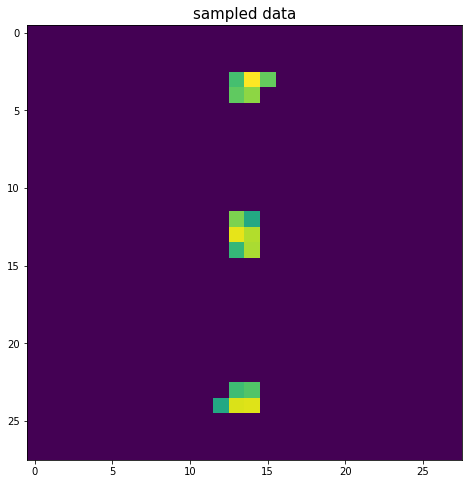

(8165, 26) (8165, 28, 28, 1) (8165, 10) (2042, 26) (2042, 28, 28, 1) (2042, 10)
training for the original model
Epoch 1/20
256/256 - 3s - loss: 1.9874 - accuracy: 0.2854 - val_loss: 1.7357 - val_accuracy: 0.3834
Epoch 2/20
256/256 - 3s - loss: 1.6136 - accuracy: 0.4332 - val_loss: 1.5144 - val_accuracy: 0.4657
Epoch 3/20
256/256 - 3s - loss: 1.4457 - accuracy: 0.4923 - val_loss: 1.3146 - val_accuracy: 0.5397
Epoch 4/20
256/256 - 3s - loss: 1.2948 - accuracy: 0.5472 - val_loss: 1.2233 - val_accuracy: 0.5681
Epoch 5/20
256/256 - 3s - loss: 1.1810 - accuracy: 0.5784 - val_loss: 1.1637 - val_accuracy: 0.5935
Epoch 6/20
256/256 - 3s - loss: 1.0843 - accuracy: 0.6209 - val_loss: 1.0374 - val_accuracy: 0.6396
Epoch 7/20
256/256 - 3s - loss: 0.9942 - accuracy: 0.6521 - val_loss: 0.9987 - val_accuracy: 0.6484
Epoch 8/20
256/256 - 3s - loss: 0.9226 - accuracy: 0.6779 - val_loss: 0.9962 - val_accuracy: 0.6592
Epoch 9/20
256/256 - 3s - loss: 0.8402 - accuracy: 0.7070 - val_loss: 0.9081 - val_accur

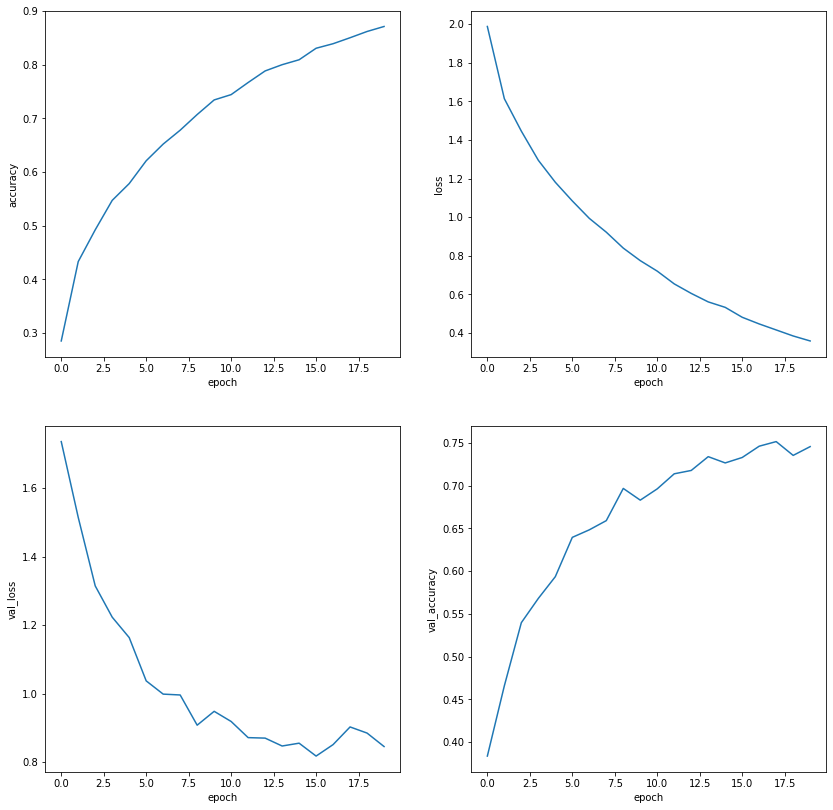

7/7 - 0s - loss: 1.5693 - accuracy: 0.6439
test_loss :  1.5693339109420776 test_acc :  0.6439024209976196
testing for medel 1
(22528, 28, 28, 1) (22528, 26)
training for embedding model
Epoch 1/30
564/564 - 6s - loss: 1.9603 - accuracy: 0.4213 - val_loss: 0.9531 - val_accuracy: 0.7042
Epoch 2/30
564/564 - 6s - loss: 0.8007 - accuracy: 0.7498 - val_loss: 0.5314 - val_accuracy: 0.8311
Epoch 3/30
564/564 - 6s - loss: 0.5523 - accuracy: 0.8271 - val_loss: 0.4501 - val_accuracy: 0.8482
Epoch 4/30
564/564 - 6s - loss: 0.4443 - accuracy: 0.8580 - val_loss: 0.3689 - val_accuracy: 0.8777
Epoch 5/30
564/564 - 6s - loss: 0.3822 - accuracy: 0.8760 - val_loss: 0.3497 - val_accuracy: 0.8862
Epoch 6/30
564/564 - 6s - loss: 0.3392 - accuracy: 0.8896 - val_loss: 0.3126 - val_accuracy: 0.8959
Epoch 7/30
564/564 - 6s - loss: 0.2995 - accuracy: 0.9005 - val_loss: 0.2948 - val_accuracy: 0.9030
Epoch 8/30
564/564 - 6s - loss: 0.2698 - accuracy: 0.9086 - val_loss: 0.2657 - val_accuracy: 0.9101
Epoch 9/30
564

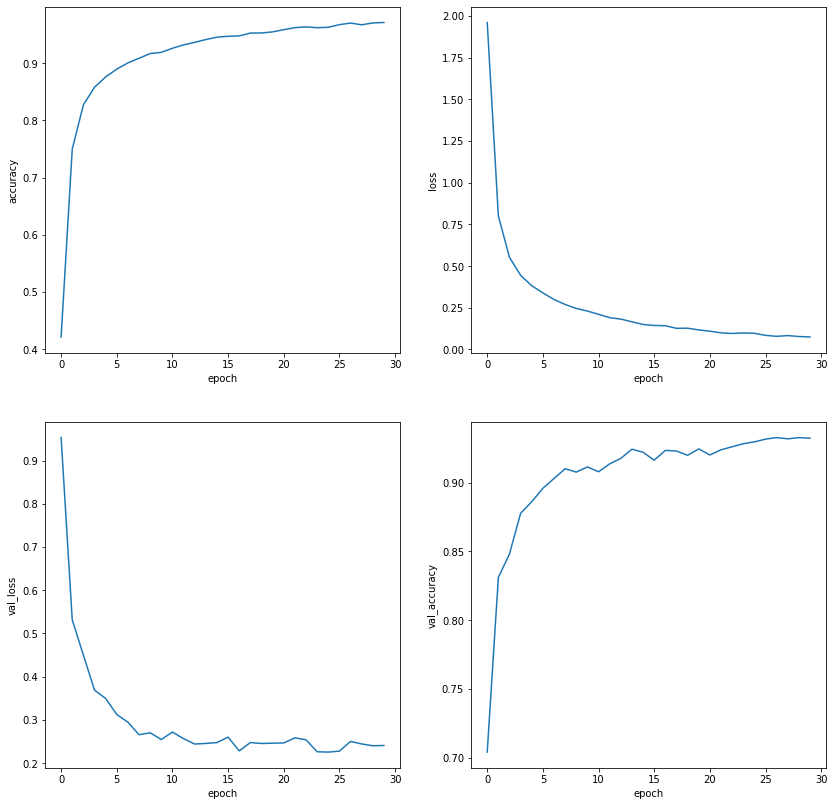

Epoch 1/20
256/256 - 3s - loss: 2.1251 - accuracy: 0.2511 - val_loss: 1.8061 - val_accuracy: 0.3643
Epoch 2/20
256/256 - 3s - loss: 1.6531 - accuracy: 0.4242 - val_loss: 1.5625 - val_accuracy: 0.4496
Epoch 3/20
256/256 - 3s - loss: 1.4461 - accuracy: 0.4905 - val_loss: 1.3940 - val_accuracy: 0.5005
Epoch 4/20
256/256 - 3s - loss: 1.3192 - accuracy: 0.5412 - val_loss: 1.3516 - val_accuracy: 0.5411
Epoch 5/20
256/256 - 3s - loss: 1.2201 - accuracy: 0.5716 - val_loss: 1.2629 - val_accuracy: 0.5583
Epoch 6/20
256/256 - 3s - loss: 1.1256 - accuracy: 0.6009 - val_loss: 1.1495 - val_accuracy: 0.5955
Epoch 7/20
256/256 - 3s - loss: 1.0542 - accuracy: 0.6307 - val_loss: 1.1261 - val_accuracy: 0.6170
Epoch 8/20
256/256 - 3s - loss: 0.9801 - accuracy: 0.6536 - val_loss: 1.1290 - val_accuracy: 0.6146
Epoch 9/20
256/256 - 3s - loss: 0.9047 - accuracy: 0.6827 - val_loss: 1.0392 - val_accuracy: 0.6430
Epoch 10/20
256/256 - 3s - loss: 0.8281 - accuracy: 0.7115 - val_loss: 1.0208 - val_accuracy: 0.6454

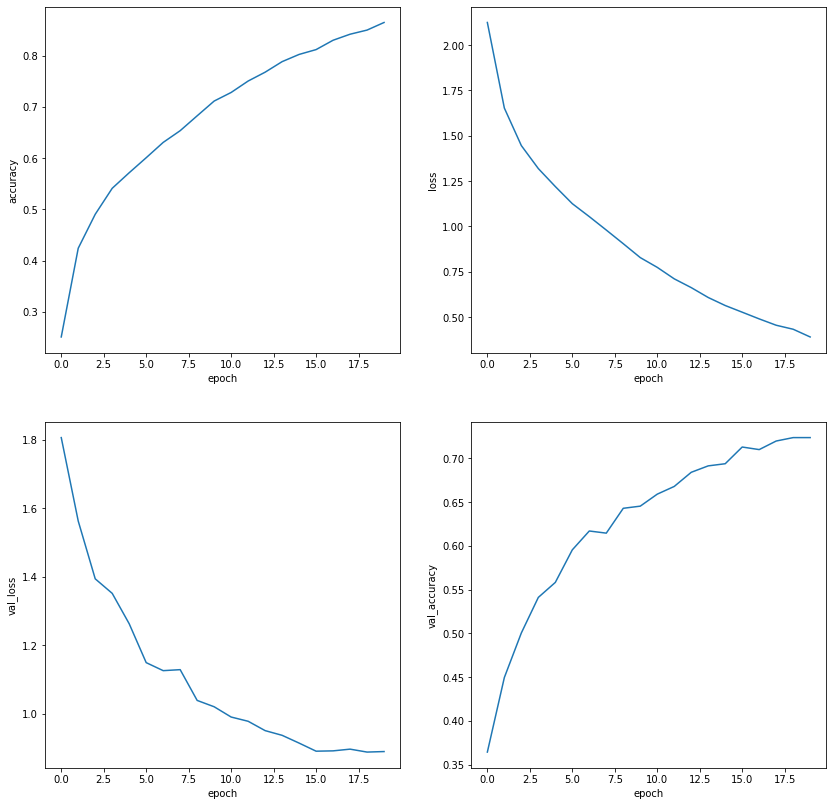

7/7 - 0s - loss: 6.4395 - accuracy: 0.3268
test_loss :  6.439469814300537 test_acc :  0.3268292546272278


In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import layers, Sequential

from sklearn.model_selection import train_test_split
import string

seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)
ImageGen_coeff = 5
epochs_num1 = 30  # embedding
epochs_num2 = 20  # classifier
train_ratio = 0.9
verbose = 2

path = '/content/gdrive/My Drive/Dacon/ComputerVision/'

path_train = path + 'train.csv'
path_test = path + 'test.csv'
path_submission = path + 'submission.csv'

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

def read_train_and_split(path,train_ratio):
    train = pd.read_csv(path)
    point_to = int(len(train) * train_ratio)
    train_data = train.iloc[:point_to]
    test_data = train.iloc[point_to:]
    return train_data, test_data

def data_reparametrization(elt):
    if elt >= 150:
        return elt/255.
    else:
        return 0

def data_reparametrization_emb(elt):
    if elt >= 50:
        return 1
    else:
        return 0

def generate_letter_hash():
    letter_hash = dict(zip(string.ascii_uppercase, [[1 if i == j else 0 for j in range(26)] for i in range(26) ]))
    return letter_hash

def data_split(train_data):
    pix = train_data.iloc[:, 3:].applymap(data_reparametrization).values.reshape(-1, 28, 28, 1)               
    fix = train_data.iloc[:, 1:3].values
    ######################
    plt.rcParams['figure.figsize'] = [8, 8]
    plt.imshow(pix[0].reshape((28,28)))
    plt.title('sampled data', fontsize = 15)
    plt.show()
    ######################

    datagenerator = ImageDataGenerator(rotation_range=10, zoom_range=0.10, width_shift_range=0.1,
                                       height_shift_range=0.1)
    gen = datagenerator.flow(pix, fix, shuffle = False, batch_size = 32)
    pixel, fixed, batch_index, limit = [], [], 0, 64 * ImageGen_coeff
    while batch_index <= limit:
        try:
            data = gen.next()
            pixel += list(data[0])
            fixed += list(data[1])
            batch_index += 1
        except:
            print("ImageGeneratorError")
            break
    fixed = np.asarray(fixed)
    pixel = np.asarray(pixel)

    X_train_pixel, X_valid_pixel, fixed_train, fixed_valid = train_test_split(pixel, fixed, test_size=0.2,
                                                                              random_state=seed)

    Y_train = to_categorical(fixed_train[:, 0], 10)
    Y_valid = to_categorical(fixed_valid[:, 0], 10)

    letter_hash = generate_letter_hash()
    X_train_label = np.asarray([letter_hash[letter] for letter in fixed_train[:, 1]])
    X_valid_label = np.asarray([letter_hash[letter] for letter in fixed_valid[:, 1]])

    return X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid

def plot_history(history):
    plt.rcParams['figure.figsize'] = [14, 14]
    fig = plt.figure()
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4)

    ax1.plot(history.history['accuracy'])
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')

    ax2.plot(history.history['loss'])
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')

    ax3.plot(history.history['val_loss'])
    ax3.set_xlabel('epoch')
    ax3.set_ylabel('val_loss')

    ax4.plot(history.history['val_accuracy'])
    ax4.set_xlabel('epoch')
    ax4.set_ylabel('val_accuracy')

    plt.show()

def train_model(model, epochs_num, rate, em_model):
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    annealer = LearningRateScheduler(lambda x: 1e-3 * rate ** x)
    with tf.device('/device:GPU:0'):
        history = model.fit([X_train_pixel, X_train_label, em_model.predict(X_train_pixel)], Y_train, epochs=epochs_num,
                            validation_data=([X_valid_pixel, X_valid_label, em_model.predict(X_valid_pixel)], Y_valid), callbacks=[annealer], verbose=verbose)
    print(
        f"CNN: Epochs={epochs_num:d}, " +
        f"Train accuracy={max(history.history['accuracy']):.5f}, " +
        f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
    )
    plot_history(history)

    return model

def test_result(model, test_data, em_model):
    letter_hash = generate_letter_hash()

    X_test_pixel = test_data.iloc[:, 3:].applymap(data_reparametrization).values.reshape(-1, 28, 28, 1)
    X_test_pixel_emb = test_data.iloc[:, 3:].applymap(data_reparametrization_emb).values.reshape(-1, 28, 28, 1)
    X_test_label = np.array([letter_hash[letter] for letter in test_data.iloc[:, 2]])
    Y_test = to_categorical(test_data.iloc[:, 1], 10)

    test_loss, test_acc = model.evaluate([X_test_pixel, X_test_label, em_model.predict(X_test_pixel_emb)],  Y_test, verbose=2)
    print('test_loss : ', test_loss, 'test_acc : ', test_acc)
    return test_acc


train_data, test_data = read_train_and_split(path_train,train_ratio)
X_train_label, X_train_pixel, Y_train, X_valid_label, X_valid_pixel, Y_valid = data_split(train_data)
print(X_train_label.shape, X_train_pixel.shape, Y_train.shape, X_valid_label.shape, X_valid_pixel.shape, Y_valid.shape)

################################################################################################################################0
print('training for the original model')
def train_and_save_model(model, epochs_num, rate):
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    annealer = LearningRateScheduler(lambda x: 1e-3 * rate ** x)
    with tf.device('/device:GPU:0'):
        history = model.fit([X_train_pixel, X_train_label], Y_train, epochs=epochs_num,
                            validation_data=([X_valid_pixel, X_valid_label], Y_valid), callbacks=[annealer], verbose=verbose)
    print(
        f"CNN: Epochs={epochs_num:d}, " +
        f"Train accuracy={max(history.history['accuracy']):.5f}, " +
        f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
    )
    plot_history(history)
    
    return model

def test_result0(model, test_data):
    letter_hash = generate_letter_hash()

    X_test_pixel = test_data.iloc[:, 3:].applymap(data_reparametrization).values.reshape(-1, 28, 28, 1)
    X_test_label = np.array([letter_hash[letter] for letter in test_data.iloc[:, 2]])
    Y_test = to_categorical(test_data.iloc[:, 1], 10)

    test_loss, test_acc = model.evaluate([X_test_pixel, X_test_label],  Y_test, verbose=verbose)
    print('test_loss : ', test_loss, 'test_acc : ', test_acc)

def multi_input_cnn_dense_model_1():
    cnn_input = layers.Input(shape = (28, 28, 1))
    cnn_mid = layers.Conv2D(32, kernel_size=3, activation='relu')(cnn_input)
    cnn_mid = layers.Conv2D(32, kernel_size=3, activation='relu')(cnn_mid)
    cnn_mid = layers.Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu')(cnn_mid)
    cnn_mid = layers.Dropout(0.4)(cnn_mid)
    cnn_mid = layers.Conv2D(64, kernel_size=3, activation='relu')(cnn_mid)
    cnn_mid = layers.Conv2D(64, kernel_size=3, activation='relu')(cnn_mid)
    cnn_mid = layers.Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu')(cnn_mid)
    cnn_mid = layers.Dropout(0.4)(cnn_mid)
    cnn_mid = layers.Conv2D(128, kernel_size=4, activation='relu')(cnn_mid)
    cnn_output = layers.Flatten()(cnn_mid)
    cnn_model = tf.keras.Model(inputs = cnn_input, outputs = cnn_output)

    dense_input = layers.Input(shape=(26,))
    dense_mid = layers.Dense(52)(dense_input)
    dense_mid = layers.BatchNormalization()(dense_mid)
    dense_mid = layers.Activation('relu')(dense_mid)
    dense_mid = layers.Dense(52, activation = 'relu')(dense_mid)
    dense_mid = layers.Dropout(0.4)(dense_mid)
    dense_output = layers.Dense(52)(dense_mid)
    dense_model = tf.keras.Model(inputs = dense_input, outputs = dense_output)

    concatenated = layers.concatenate([cnn_model.output, dense_model.output])
    concatenated = layers.Dense(32, activation = 'relu')(concatenated)
    concat_output = layers.Dense(10, activation='softmax')(concatenated)
    concat_model = tf.keras.models.Model([cnn_input, dense_input],concat_output)

    return concat_model
try:
    model = multi_input_cnn_dense_model_1()
    plot_model(model, show_shapes=True)
    model = train_and_save_model(model, epochs_num2, 0.95)
    test_result0(model, test_data)
except:
    print("1 pass")
    pass

################################################################################################################################1
i = 1
print("testing for medel",i)
def generate_letter_embedding(epochs_num):
    letter_hash = generate_letter_hash()

    train_data = pd.read_csv(path_train)
    test_data = pd.read_csv(path_test)
    Y = [letter_hash[letter] for letter in train_data.iloc[:,2]] + [letter_hash[letter] for letter in test_data.iloc[:,1]]
    Y = np.array(Y)
    X = np.concatenate((train_data.iloc[:,3:].applymap(data_reparametrization_emb).values, test_data.iloc[:,2:].applymap(data_reparametrization_emb).values), axis = 0).reshape(-1,28,28,1)
    print(X.shape, Y.shape)
    em_input = layers.Input(shape=(28, 28, 1))
    em_mid = layers.Conv2D(32, kernel_size=3, activation='relu')(em_input)
    em_mid = layers.Conv2D(32, kernel_size=3, activation='relu')(em_mid)
    em_mid = layers.Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu')(em_mid)
    em_mid = layers.Dropout(0.4)(em_mid)
    em_mid = layers.Conv2D(64, kernel_size=3, activation='relu')(em_mid)
    em_mid = layers.Conv2D(64, kernel_size=3, activation='relu')(em_mid)
    em_mid = layers.Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu')(em_mid)
    em_mid = layers.Dropout(0.4)(em_mid)
    em_mid = layers.Conv2D(128, kernel_size=4, activation='relu')(em_mid)
    em_output = layers.Flatten()(em_mid)

    train_mid = layers.Dense(64, activation='relu')(em_output)
    train_mid = layers.Dense(64, activation='relu')(train_mid)
    train_mid = layers.Dense(32, activation='relu')(train_mid)
    train_out = layers.Dense(26, activation='softmax')(train_mid)

    em_model = tf.keras.Model(inputs=em_input, outputs=em_output)
    training_model = tf.keras.Model(inputs=em_input, outputs=train_out)

    training_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
    print('training for embedding model')
    with tf.device('/device:GPU:0'):
        history = training_model.fit(X, Y, epochs=epochs_num, validation_split = 0.2, callbacks=[annealer], verbose=verbose)
    print(
        f"CNN: Epochs={epochs_num:d}, " +
        f"Train accuracy={max(history.history['accuracy']):.5f}, " +
        f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
    )
    plot_history(history)

    return em_model

def multi_input_cnn_dense_model_1():
    cnn_input = layers.Input(shape = (28, 28, 1))
    cnn_mid = layers.Conv2D(32, kernel_size=3, activation='relu')(cnn_input)
    cnn_mid = layers.Conv2D(32, kernel_size=3, activation='relu')(cnn_mid)
    cnn_mid = layers.Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu')(cnn_mid)
    cnn_mid = layers.Dropout(0.4)(cnn_mid)
    cnn_mid = layers.Conv2D(64, kernel_size=3, activation='relu')(cnn_mid)
    cnn_mid = layers.Conv2D(64, kernel_size=3, activation='relu')(cnn_mid)
    cnn_mid = layers.Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu')(cnn_mid)
    cnn_mid = layers.Dropout(0.4)(cnn_mid)
    cnn_mid = layers.Conv2D(128, kernel_size=4, activation='relu')(cnn_mid)
    cnn_output = layers.Flatten()(cnn_mid)
    cnn_model = tf.keras.Model(inputs = cnn_input, outputs = cnn_output)

    dense_input = layers.Input(shape=(26,))
    dense_mid = layers.Dense(52)(dense_input)
    dense_mid = layers.BatchNormalization()(dense_mid)
    dense_mid = layers.Activation('relu')(dense_mid)
    dense_mid = layers.Dense(52, activation = 'relu')(dense_mid)
    dense_mid = layers.Dropout(0.4)(dense_mid)
    dense_output = layers.Dense(52)(dense_mid)
    dense_model = tf.keras.Model(inputs = dense_input, outputs = dense_output)

    embedded = layers.Input(shape=(128,))

    concatenated = layers.concatenate([cnn_model.output, dense_model.output, embedded])
    concatenated = layers.Dense(32, activation = 'relu')(concatenated)
    concat_output = layers.Dense(10, activation='softmax')(concatenated)
    concat_model = tf.keras.models.Model([cnn_input, dense_input, embedded],concat_output)

    return concat_model
try:
    em_model = generate_letter_embedding(epochs_num1)
    model = multi_input_cnn_dense_model_1()
    model = train_model(model, epochs_num2, 0.95, em_model)
    test_result(model, test_data, em_model)
except:
    print(i,"pass")
    pass
i += 1

